In [ ]:
#IMPORT & SETUP
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


2026-01-03 04:42:54.564339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767415374.738990      99 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767415374.791229      99 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767415375.205211      99 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767415375.205249      99 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767415375.205252      99 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
min/max: -1.0 1.0


I0000 00:00:1767415388.043890      99 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


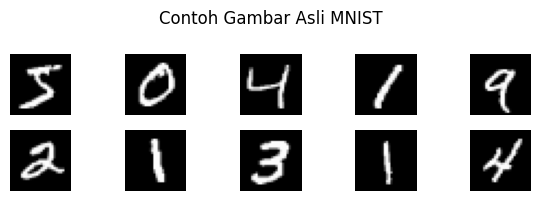

In [ ]:
# LOAD & PREPROCESS MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5   # -> [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)  # (N, 28, 28, 1)

print("min/max:", train_images.min(), train_images.max())

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

# cek contoh asli
plt.figure(figsize=(6,2))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow((train_images[i,:,:,0]+1)/2, cmap="gray")
    plt.axis("off")
plt.suptitle("Contoh Gambar Asli MNIST")
plt.tight_layout()
plt.show()


In [ ]:
# GENERATOR
NOISE_DIM = 100

def make_generator():
    model = tf.keras.Sequential(name="generator")
    model.add(layers.Input(shape=(NOISE_DIM,)))

    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, 5, strides=1, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(1, 5, strides=2, padding="same",
                                    use_bias=False, activation="tanh"))
    return model

generator = make_generator()
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
# DISCRIMINATOR
def make_discriminator():
    model = tf.keras.Sequential(name="discriminator")
    model.add(layers.Input(shape=(28, 28, 1)))

    model.add(layers.Conv2D(64, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator()
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LOSS & OPTIMIZER
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    # label smoothing untuk real agar training lebih stabil
    real_labels = tf.ones_like(real_logits) * 0.9
    fake_labels = tf.zeros_like(fake_logits)

    real_loss = cross_entropy(real_labels, real_logits)
    fake_loss = cross_entropy(fake_labels, fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

gen_optimizer  = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)


In [ ]:
# FUNCTION INSTANCE NOISE
# Instance noise membantu discriminator tidak gampang "ketipu tekstur" sehingga bentuk digit jadi lebih utuh.

def add_instance_noise(x, stddev):
    if stddev <= 0.0:
        return x
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev)


In [ ]:
# TRAIN STEP
@tf.function
def train_step(real_images, noise_stddev):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_in = add_instance_noise(real_images, noise_stddev)
        fake_in = add_instance_noise(fake_images, noise_stddev)

        real_logits = discriminator(real_in, training=True)
        fake_logits = discriminator(fake_in, training=True)

        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
# VISUALISASI HASIL
NUM_EXAMPLES = 16
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

def generate_images(title):
    preds = generator(seed, training=False)
    preds = (preds + 1.0) / 2.0  # -> [0,1]

    plt.figure(figsize=(4,4))
    for i in range(NUM_EXAMPLES):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i,:,:,0], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


E0000 00:00:1767415393.808892      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1767415394.458243     158 cuda_dnn.cc:529] Loaded cuDNN version 91002


Epoch 001/1000 | noise_std=0.100 | gen_loss=0.7475 | disc_loss=1.3622 | 13.6s


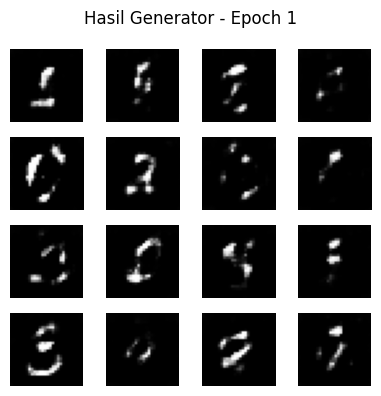

Epoch 002/1000 | noise_std=0.100 | gen_loss=0.8215 | disc_loss=1.3518 | 9.0s
Epoch 003/1000 | noise_std=0.100 | gen_loss=0.8553 | disc_loss=1.3214 | 9.0s
Epoch 004/1000 | noise_std=0.100 | gen_loss=0.8606 | disc_loss=1.3236 | 9.2s
Epoch 005/1000 | noise_std=0.100 | gen_loss=0.8428 | disc_loss=1.3437 | 8.9s
Epoch 006/1000 | noise_std=0.099 | gen_loss=0.8377 | disc_loss=1.3490 | 9.0s
Epoch 007/1000 | noise_std=0.099 | gen_loss=0.8366 | disc_loss=1.3486 | 8.9s


E0000 00:00:1767415460.088767      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 008/1000 | noise_std=0.099 | gen_loss=0.8428 | disc_loss=1.3428 | 8.9s
Epoch 009/1000 | noise_std=0.099 | gen_loss=0.8469 | disc_loss=1.3410 | 9.0s
Epoch 010/1000 | noise_std=0.099 | gen_loss=0.8491 | disc_loss=1.3381 | 9.0s


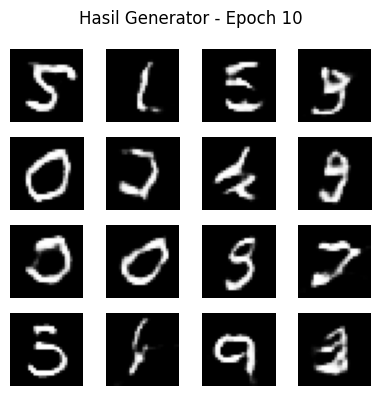

Epoch 011/1000 | noise_std=0.099 | gen_loss=0.8525 | disc_loss=1.3360 | 9.0s
Epoch 012/1000 | noise_std=0.099 | gen_loss=0.8565 | disc_loss=1.3338 | 8.9s
Epoch 013/1000 | noise_std=0.099 | gen_loss=0.8507 | disc_loss=1.3360 | 8.9s
Epoch 014/1000 | noise_std=0.099 | gen_loss=0.8596 | disc_loss=1.3348 | 8.9s


E0000 00:00:1767415522.871016      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 015/1000 | noise_std=0.099 | gen_loss=0.8565 | disc_loss=1.3359 | 8.9s
Epoch 016/1000 | noise_std=0.098 | gen_loss=0.8481 | disc_loss=1.3405 | 9.2s
Epoch 017/1000 | noise_std=0.098 | gen_loss=0.8571 | disc_loss=1.3374 | 9.0s
Epoch 018/1000 | noise_std=0.098 | gen_loss=0.8537 | disc_loss=1.3391 | 9.0s
Epoch 019/1000 | noise_std=0.098 | gen_loss=0.8533 | disc_loss=1.3416 | 9.0s
Epoch 020/1000 | noise_std=0.098 | gen_loss=0.8498 | disc_loss=1.3427 | 8.9s


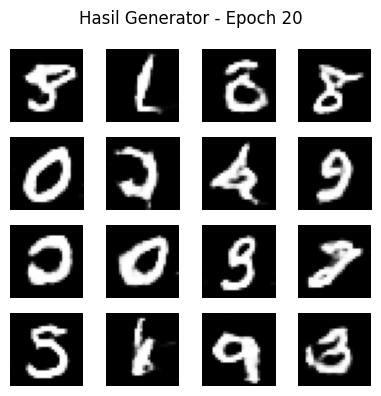

Epoch 021/1000 | noise_std=0.098 | gen_loss=0.8425 | disc_loss=1.3455 | 9.0s


E0000 00:00:1767415586.041425      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 022/1000 | noise_std=0.098 | gen_loss=0.8567 | disc_loss=1.3407 | 9.0s
Epoch 023/1000 | noise_std=0.098 | gen_loss=0.8440 | disc_loss=1.3462 | 9.0s
Epoch 024/1000 | noise_std=0.098 | gen_loss=0.8490 | disc_loss=1.3449 | 9.0s
Epoch 025/1000 | noise_std=0.098 | gen_loss=0.8476 | disc_loss=1.3457 | 9.0s
Epoch 026/1000 | noise_std=0.097 | gen_loss=0.8413 | disc_loss=1.3496 | 8.9s
Epoch 027/1000 | noise_std=0.097 | gen_loss=0.8462 | disc_loss=1.3468 | 9.0s
Epoch 028/1000 | noise_std=0.097 | gen_loss=0.8424 | disc_loss=1.3475 | 9.0s


E0000 00:00:1767415648.855028      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 029/1000 | noise_std=0.097 | gen_loss=0.8390 | disc_loss=1.3508 | 9.0s
Epoch 030/1000 | noise_std=0.097 | gen_loss=0.8443 | disc_loss=1.3499 | 9.3s


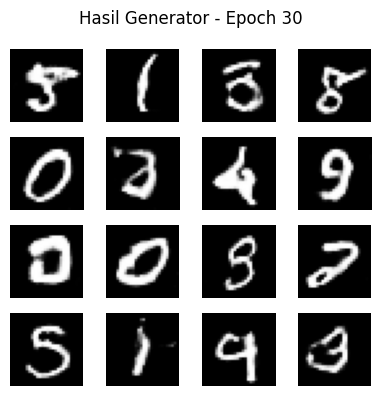

Epoch 031/1000 | noise_std=0.097 | gen_loss=0.8362 | disc_loss=1.3538 | 8.9s
Epoch 032/1000 | noise_std=0.097 | gen_loss=0.8384 | disc_loss=1.3527 | 8.9s
Epoch 033/1000 | noise_std=0.097 | gen_loss=0.8342 | disc_loss=1.3530 | 9.0s
Epoch 034/1000 | noise_std=0.097 | gen_loss=0.8361 | disc_loss=1.3542 | 8.9s
Epoch 035/1000 | noise_std=0.097 | gen_loss=0.8335 | disc_loss=1.3537 | 8.9s


E0000 00:00:1767415712.074955      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 036/1000 | noise_std=0.096 | gen_loss=0.8361 | disc_loss=1.3542 | 9.0s
Epoch 037/1000 | noise_std=0.096 | gen_loss=0.8320 | disc_loss=1.3562 | 8.9s
Epoch 038/1000 | noise_std=0.096 | gen_loss=0.8321 | disc_loss=1.3562 | 9.0s
Epoch 039/1000 | noise_std=0.096 | gen_loss=0.8304 | disc_loss=1.3581 | 8.9s
Epoch 040/1000 | noise_std=0.096 | gen_loss=0.8312 | disc_loss=1.3572 | 8.9s


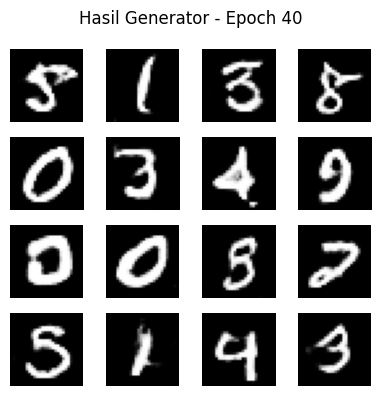

Epoch 041/1000 | noise_std=0.096 | gen_loss=0.8281 | disc_loss=1.3586 | 9.0s
Epoch 042/1000 | noise_std=0.096 | gen_loss=0.8264 | disc_loss=1.3594 | 9.0s


E0000 00:00:1767415774.984637      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 043/1000 | noise_std=0.096 | gen_loss=0.8277 | disc_loss=1.3590 | 9.0s
Epoch 044/1000 | noise_std=0.096 | gen_loss=0.8251 | disc_loss=1.3612 | 9.0s
Epoch 045/1000 | noise_std=0.096 | gen_loss=0.8288 | disc_loss=1.3592 | 9.5s
Epoch 046/1000 | noise_std=0.095 | gen_loss=0.8239 | disc_loss=1.3611 | 9.0s
Epoch 047/1000 | noise_std=0.095 | gen_loss=0.8274 | disc_loss=1.3606 | 8.9s
Epoch 048/1000 | noise_std=0.095 | gen_loss=0.8225 | disc_loss=1.3628 | 9.0s
Epoch 049/1000 | noise_std=0.095 | gen_loss=0.8216 | disc_loss=1.3625 | 8.9s


E0000 00:00:1767415838.214839      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 050/1000 | noise_std=0.095 | gen_loss=0.8225 | disc_loss=1.3628 | 9.0s


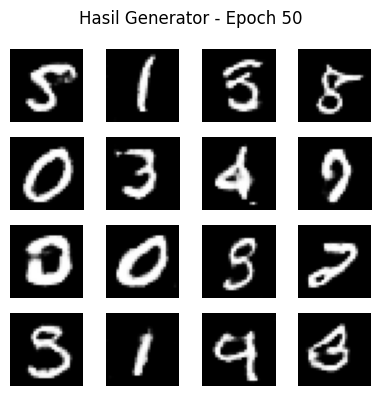

Epoch 051/1000 | noise_std=0.095 | gen_loss=0.8233 | disc_loss=1.3630 | 8.9s
Epoch 052/1000 | noise_std=0.095 | gen_loss=0.8226 | disc_loss=1.3625 | 9.0s
Epoch 053/1000 | noise_std=0.095 | gen_loss=0.8201 | disc_loss=1.3639 | 8.9s
Epoch 054/1000 | noise_std=0.095 | gen_loss=0.8238 | disc_loss=1.3621 | 8.9s
Epoch 055/1000 | noise_std=0.095 | gen_loss=0.8189 | disc_loss=1.3654 | 9.0s
Epoch 056/1000 | noise_std=0.094 | gen_loss=0.8201 | disc_loss=1.3646 | 9.0s


E0000 00:00:1767415900.994333      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 057/1000 | noise_std=0.094 | gen_loss=0.8213 | disc_loss=1.3634 | 8.9s
Epoch 058/1000 | noise_std=0.094 | gen_loss=0.8184 | disc_loss=1.3652 | 9.0s
Epoch 059/1000 | noise_std=0.094 | gen_loss=0.8190 | disc_loss=1.3641 | 9.0s
Epoch 060/1000 | noise_std=0.094 | gen_loss=0.8176 | disc_loss=1.3660 | 8.9s


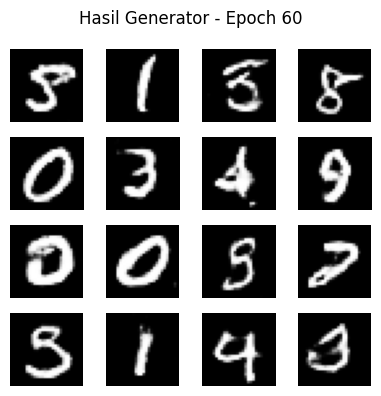

Epoch 061/1000 | noise_std=0.094 | gen_loss=0.8205 | disc_loss=1.3642 | 9.0s
Epoch 062/1000 | noise_std=0.094 | gen_loss=0.8190 | disc_loss=1.3647 | 9.0s
Epoch 063/1000 | noise_std=0.094 | gen_loss=0.8169 | disc_loss=1.3662 | 9.0s


E0000 00:00:1767415964.756828      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 064/1000 | noise_std=0.094 | gen_loss=0.8229 | disc_loss=1.3629 | 9.7s
Epoch 065/1000 | noise_std=0.094 | gen_loss=0.8178 | disc_loss=1.3650 | 9.0s
Epoch 066/1000 | noise_std=0.093 | gen_loss=0.8174 | disc_loss=1.3658 | 9.0s
Epoch 067/1000 | noise_std=0.093 | gen_loss=0.8186 | disc_loss=1.3648 | 9.0s
Epoch 068/1000 | noise_std=0.093 | gen_loss=0.8209 | disc_loss=1.3638 | 9.0s
Epoch 069/1000 | noise_std=0.093 | gen_loss=0.8177 | disc_loss=1.3646 | 9.0s
Epoch 070/1000 | noise_std=0.093 | gen_loss=0.8164 | disc_loss=1.3665 | 9.0s


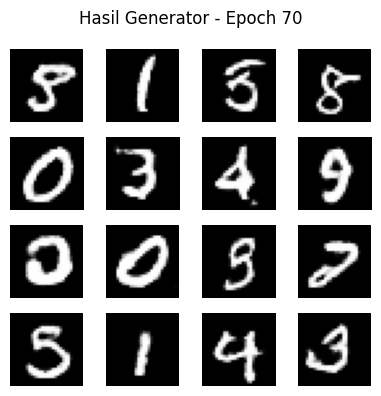

E0000 00:00:1767416027.942770      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 071/1000 | noise_std=0.093 | gen_loss=0.8165 | disc_loss=1.3659 | 9.0s
Epoch 072/1000 | noise_std=0.093 | gen_loss=0.8186 | disc_loss=1.3650 | 9.0s
Epoch 073/1000 | noise_std=0.093 | gen_loss=0.8181 | disc_loss=1.3658 | 9.0s
Epoch 074/1000 | noise_std=0.093 | gen_loss=0.8164 | disc_loss=1.3663 | 9.0s
Epoch 075/1000 | noise_std=0.093 | gen_loss=0.8172 | disc_loss=1.3657 | 9.0s
Epoch 076/1000 | noise_std=0.092 | gen_loss=0.8177 | disc_loss=1.3653 | 9.0s
Epoch 077/1000 | noise_std=0.092 | gen_loss=0.8170 | disc_loss=1.3659 | 9.0s


E0000 00:00:1767416090.828013      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 078/1000 | noise_std=0.092 | gen_loss=0.8166 | disc_loss=1.3663 | 9.0s
Epoch 079/1000 | noise_std=0.092 | gen_loss=0.8164 | disc_loss=1.3659 | 9.0s
Epoch 080/1000 | noise_std=0.092 | gen_loss=0.8179 | disc_loss=1.3664 | 9.0s


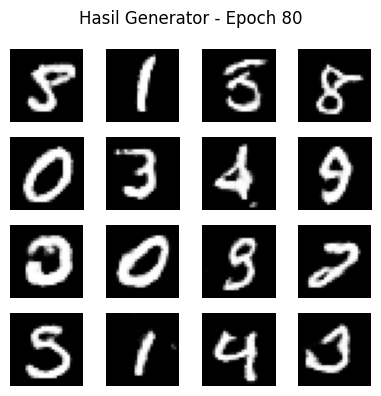

Epoch 081/1000 | noise_std=0.092 | gen_loss=0.8177 | disc_loss=1.3651 | 9.0s
Epoch 082/1000 | noise_std=0.092 | gen_loss=0.8165 | disc_loss=1.3656 | 9.0s
Epoch 083/1000 | noise_std=0.092 | gen_loss=0.8170 | disc_loss=1.3663 | 9.0s
Epoch 084/1000 | noise_std=0.092 | gen_loss=0.8176 | disc_loss=1.3650 | 9.0s


E0000 00:00:1767416154.020845      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 085/1000 | noise_std=0.092 | gen_loss=0.8163 | disc_loss=1.3662 | 9.0s
Epoch 086/1000 | noise_std=0.091 | gen_loss=0.8169 | disc_loss=1.3654 | 9.0s
Epoch 087/1000 | noise_std=0.091 | gen_loss=0.8184 | disc_loss=1.3648 | 9.0s
Epoch 088/1000 | noise_std=0.091 | gen_loss=0.8166 | disc_loss=1.3663 | 9.8s
Epoch 089/1000 | noise_std=0.091 | gen_loss=0.8167 | disc_loss=1.3663 | 9.0s
Epoch 090/1000 | noise_std=0.091 | gen_loss=0.8170 | disc_loss=1.3654 | 9.0s


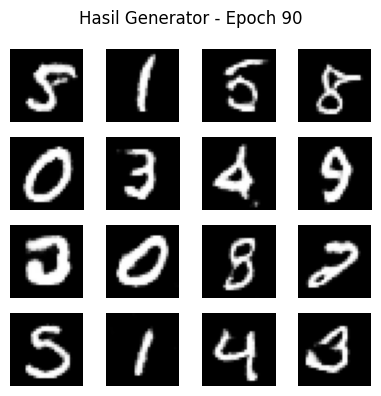

Epoch 091/1000 | noise_std=0.091 | gen_loss=0.8180 | disc_loss=1.3654 | 9.0s


E0000 00:00:1767416217.978512      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 092/1000 | noise_std=0.091 | gen_loss=0.8167 | disc_loss=1.3660 | 9.0s
Epoch 093/1000 | noise_std=0.091 | gen_loss=0.8168 | disc_loss=1.3659 | 9.0s
Epoch 094/1000 | noise_std=0.091 | gen_loss=0.8165 | disc_loss=1.3664 | 9.0s
Epoch 095/1000 | noise_std=0.091 | gen_loss=0.8156 | disc_loss=1.3672 | 9.0s
Epoch 096/1000 | noise_std=0.090 | gen_loss=0.8163 | disc_loss=1.3665 | 9.0s
Epoch 097/1000 | noise_std=0.090 | gen_loss=0.8164 | disc_loss=1.3658 | 9.0s
Epoch 098/1000 | noise_std=0.090 | gen_loss=0.8156 | disc_loss=1.3672 | 9.0s


E0000 00:00:1767416280.884942      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 099/1000 | noise_std=0.090 | gen_loss=0.8163 | disc_loss=1.3662 | 9.0s
Epoch 100/1000 | noise_std=0.090 | gen_loss=0.8184 | disc_loss=1.3655 | 9.0s


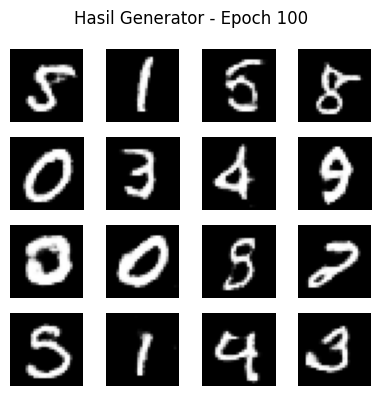

Epoch 101/1000 | noise_std=0.090 | gen_loss=0.8161 | disc_loss=1.3663 | 9.0s
Epoch 102/1000 | noise_std=0.090 | gen_loss=0.8164 | disc_loss=1.3657 | 9.0s
Epoch 103/1000 | noise_std=0.090 | gen_loss=0.8154 | disc_loss=1.3672 | 9.0s
Epoch 104/1000 | noise_std=0.090 | gen_loss=0.8160 | disc_loss=1.3667 | 9.0s
Epoch 105/1000 | noise_std=0.090 | gen_loss=0.8158 | disc_loss=1.3669 | 9.0s


E0000 00:00:1767416343.998693      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 106/1000 | noise_std=0.089 | gen_loss=0.8155 | disc_loss=1.3673 | 8.9s
Epoch 107/1000 | noise_std=0.089 | gen_loss=0.8158 | disc_loss=1.3665 | 9.0s
Epoch 108/1000 | noise_std=0.089 | gen_loss=0.8157 | disc_loss=1.3669 | 9.0s
Epoch 109/1000 | noise_std=0.089 | gen_loss=0.8144 | disc_loss=1.3681 | 9.0s
Epoch 110/1000 | noise_std=0.089 | gen_loss=0.8160 | disc_loss=1.3667 | 9.0s


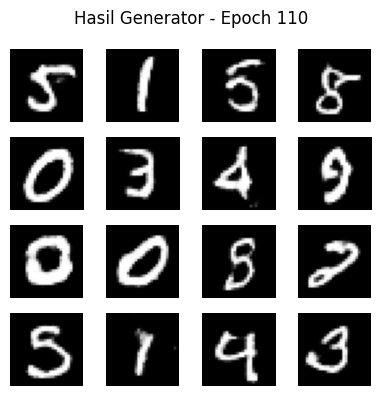

Epoch 111/1000 | noise_std=0.089 | gen_loss=0.8150 | disc_loss=1.3676 | 8.9s
Epoch 112/1000 | noise_std=0.089 | gen_loss=0.8144 | disc_loss=1.3681 | 8.9s


E0000 00:00:1767416406.877431      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 113/1000 | noise_std=0.089 | gen_loss=0.8142 | disc_loss=1.3681 | 8.9s
Epoch 114/1000 | noise_std=0.089 | gen_loss=0.8139 | disc_loss=1.3680 | 9.0s
Epoch 115/1000 | noise_std=0.089 | gen_loss=0.8144 | disc_loss=1.3681 | 9.9s
Epoch 116/1000 | noise_std=0.088 | gen_loss=0.8144 | disc_loss=1.3684 | 9.0s
Epoch 117/1000 | noise_std=0.088 | gen_loss=0.8137 | disc_loss=1.3682 | 9.0s
Epoch 118/1000 | noise_std=0.088 | gen_loss=0.8140 | disc_loss=1.3685 | 9.0s
Epoch 119/1000 | noise_std=0.088 | gen_loss=0.8136 | disc_loss=1.3688 | 8.9s


E0000 00:00:1767416470.545585      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 120/1000 | noise_std=0.088 | gen_loss=0.8139 | disc_loss=1.3684 | 9.0s


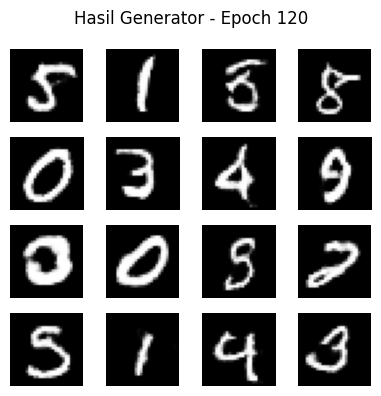

Epoch 121/1000 | noise_std=0.088 | gen_loss=0.8135 | disc_loss=1.3686 | 9.0s
Epoch 122/1000 | noise_std=0.088 | gen_loss=0.8143 | disc_loss=1.3685 | 9.0s
Epoch 123/1000 | noise_std=0.088 | gen_loss=0.8124 | disc_loss=1.3694 | 9.0s
Epoch 124/1000 | noise_std=0.088 | gen_loss=0.8138 | disc_loss=1.3684 | 9.0s
Epoch 125/1000 | noise_std=0.088 | gen_loss=0.8128 | disc_loss=1.3691 | 9.0s
Epoch 126/1000 | noise_std=0.087 | gen_loss=0.8127 | disc_loss=1.3695 | 9.0s


E0000 00:00:1767416533.637761      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 127/1000 | noise_std=0.087 | gen_loss=0.8121 | disc_loss=1.3700 | 9.0s
Epoch 128/1000 | noise_std=0.087 | gen_loss=0.8122 | disc_loss=1.3697 | 9.0s
Epoch 129/1000 | noise_std=0.087 | gen_loss=0.8131 | disc_loss=1.3689 | 9.0s
Epoch 130/1000 | noise_std=0.087 | gen_loss=0.8119 | disc_loss=1.3697 | 9.0s


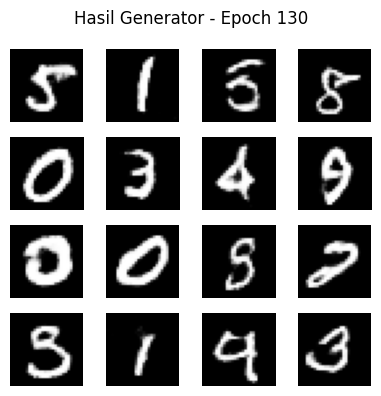

Epoch 131/1000 | noise_std=0.087 | gen_loss=0.8123 | disc_loss=1.3695 | 9.0s
Epoch 132/1000 | noise_std=0.087 | gen_loss=0.8122 | disc_loss=1.3695 | 9.0s
Epoch 133/1000 | noise_std=0.087 | gen_loss=0.8112 | disc_loss=1.3706 | 9.0s


E0000 00:00:1767416596.592193      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 134/1000 | noise_std=0.087 | gen_loss=0.8112 | disc_loss=1.3704 | 8.9s
Epoch 135/1000 | noise_std=0.087 | gen_loss=0.8117 | disc_loss=1.3701 | 9.0s
Epoch 136/1000 | noise_std=0.086 | gen_loss=0.8116 | disc_loss=1.3695 | 9.0s
Epoch 137/1000 | noise_std=0.086 | gen_loss=0.8109 | disc_loss=1.3705 | 9.0s
Epoch 138/1000 | noise_std=0.086 | gen_loss=0.8115 | disc_loss=1.3696 | 9.0s
Epoch 139/1000 | noise_std=0.086 | gen_loss=0.8111 | disc_loss=1.3703 | 8.9s
Epoch 140/1000 | noise_std=0.086 | gen_loss=0.8108 | disc_loss=1.3707 | 9.0s


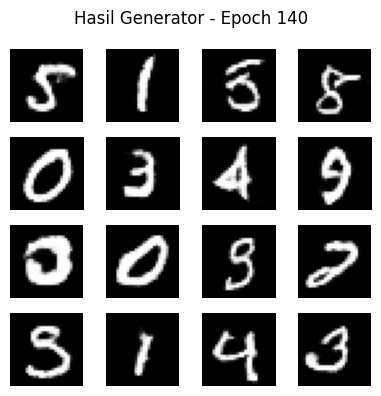

E0000 00:00:1767416659.539707      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 141/1000 | noise_std=0.086 | gen_loss=0.8107 | disc_loss=1.3703 | 9.0s
Epoch 142/1000 | noise_std=0.086 | gen_loss=0.8114 | disc_loss=1.3700 | 8.9s
Epoch 143/1000 | noise_std=0.086 | gen_loss=0.8101 | disc_loss=1.3714 | 9.0s
Epoch 144/1000 | noise_std=0.086 | gen_loss=0.8102 | disc_loss=1.3707 | 9.0s
Epoch 145/1000 | noise_std=0.086 | gen_loss=0.8115 | disc_loss=1.3706 | 8.9s
Epoch 146/1000 | noise_std=0.085 | gen_loss=0.8101 | disc_loss=1.3707 | 8.9s
Epoch 147/1000 | noise_std=0.085 | gen_loss=0.8095 | disc_loss=1.3717 | 10.1s


E0000 00:00:1767416723.352608      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 148/1000 | noise_std=0.085 | gen_loss=0.8101 | disc_loss=1.3710 | 8.9s
Epoch 149/1000 | noise_std=0.085 | gen_loss=0.8095 | disc_loss=1.3714 | 9.0s
Epoch 150/1000 | noise_std=0.085 | gen_loss=0.8095 | disc_loss=1.3713 | 9.0s


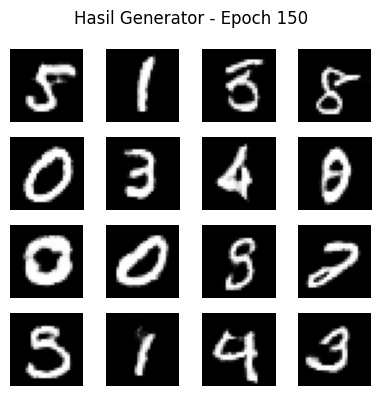

Epoch 151/1000 | noise_std=0.085 | gen_loss=0.8096 | disc_loss=1.3714 | 9.0s
Epoch 152/1000 | noise_std=0.085 | gen_loss=0.8100 | disc_loss=1.3713 | 9.0s
Epoch 153/1000 | noise_std=0.085 | gen_loss=0.8091 | disc_loss=1.3719 | 9.0s
Epoch 154/1000 | noise_std=0.085 | gen_loss=0.8098 | disc_loss=1.3710 | 9.0s


E0000 00:00:1767416786.319504      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 155/1000 | noise_std=0.085 | gen_loss=0.8095 | disc_loss=1.3713 | 9.0s
Epoch 156/1000 | noise_std=0.084 | gen_loss=0.8091 | disc_loss=1.3712 | 9.0s
Epoch 157/1000 | noise_std=0.084 | gen_loss=0.8095 | disc_loss=1.3711 | 9.0s
Epoch 158/1000 | noise_std=0.084 | gen_loss=0.8088 | disc_loss=1.3716 | 9.0s
Epoch 159/1000 | noise_std=0.084 | gen_loss=0.8088 | disc_loss=1.3720 | 9.0s
Epoch 160/1000 | noise_std=0.084 | gen_loss=0.8089 | disc_loss=1.3717 | 9.0s


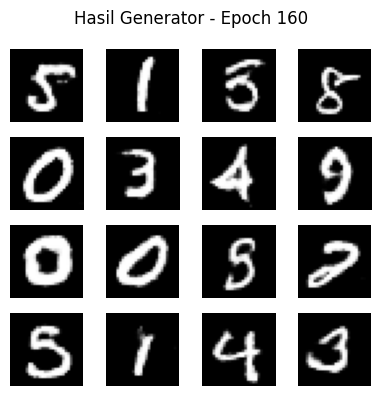

Epoch 161/1000 | noise_std=0.084 | gen_loss=0.8088 | disc_loss=1.3719 | 9.0s


E0000 00:00:1767416849.364371      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 162/1000 | noise_std=0.084 | gen_loss=0.8088 | disc_loss=1.3722 | 9.0s
Epoch 163/1000 | noise_std=0.084 | gen_loss=0.8085 | disc_loss=1.3722 | 9.0s
Epoch 164/1000 | noise_std=0.084 | gen_loss=0.8087 | disc_loss=1.3715 | 9.0s
Epoch 165/1000 | noise_std=0.084 | gen_loss=0.8093 | disc_loss=1.3714 | 9.0s
Epoch 166/1000 | noise_std=0.083 | gen_loss=0.8082 | disc_loss=1.3726 | 9.0s
Epoch 167/1000 | noise_std=0.083 | gen_loss=0.8085 | disc_loss=1.3722 | 9.0s
Epoch 168/1000 | noise_std=0.083 | gen_loss=0.8081 | disc_loss=1.3720 | 9.0s


E0000 00:00:1767416912.215737      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 169/1000 | noise_std=0.083 | gen_loss=0.8087 | disc_loss=1.3718 | 9.0s
Epoch 170/1000 | noise_std=0.083 | gen_loss=0.8080 | disc_loss=1.3721 | 9.0s


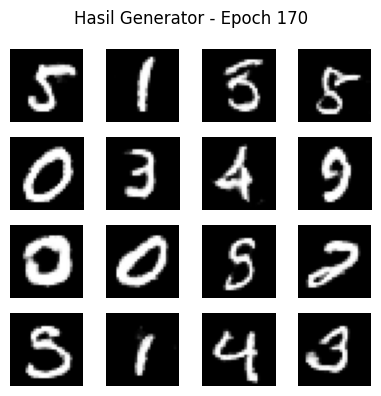

Epoch 171/1000 | noise_std=0.083 | gen_loss=0.8076 | disc_loss=1.3733 | 9.0s
Epoch 172/1000 | noise_std=0.083 | gen_loss=0.8078 | disc_loss=1.3725 | 9.0s
Epoch 173/1000 | noise_std=0.083 | gen_loss=0.8075 | disc_loss=1.3722 | 9.0s
Epoch 174/1000 | noise_std=0.083 | gen_loss=0.8084 | disc_loss=1.3726 | 9.0s
Epoch 175/1000 | noise_std=0.083 | gen_loss=0.8072 | disc_loss=1.3729 | 9.0s


E0000 00:00:1767416975.253983      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 176/1000 | noise_std=0.082 | gen_loss=0.8074 | disc_loss=1.3726 | 9.0s
Epoch 177/1000 | noise_std=0.082 | gen_loss=0.8068 | disc_loss=1.3732 | 9.0s
Epoch 178/1000 | noise_std=0.082 | gen_loss=0.8069 | disc_loss=1.3732 | 9.0s
Epoch 179/1000 | noise_std=0.082 | gen_loss=0.8068 | disc_loss=1.3727 | 9.0s
Epoch 180/1000 | noise_std=0.082 | gen_loss=0.8070 | disc_loss=1.3725 | 9.0s


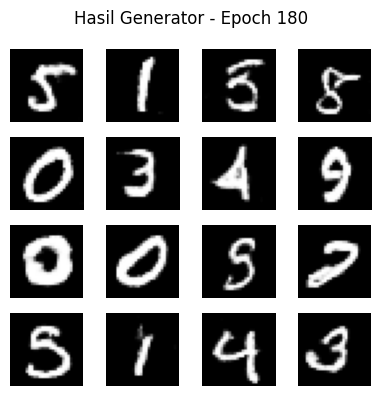

Epoch 181/1000 | noise_std=0.082 | gen_loss=0.8068 | disc_loss=1.3729 | 9.0s
Epoch 182/1000 | noise_std=0.082 | gen_loss=0.8066 | disc_loss=1.3734 | 9.0s


E0000 00:00:1767417038.321155      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 183/1000 | noise_std=0.082 | gen_loss=0.8068 | disc_loss=1.3729 | 9.0s
Epoch 184/1000 | noise_std=0.082 | gen_loss=0.8072 | disc_loss=1.3724 | 9.0s
Epoch 185/1000 | noise_std=0.082 | gen_loss=0.8061 | disc_loss=1.3737 | 9.0s
Epoch 186/1000 | noise_std=0.081 | gen_loss=0.8060 | disc_loss=1.3737 | 10.3s
Epoch 187/1000 | noise_std=0.081 | gen_loss=0.8062 | disc_loss=1.3734 | 9.0s
Epoch 188/1000 | noise_std=0.081 | gen_loss=0.8070 | disc_loss=1.3727 | 9.0s
Epoch 189/1000 | noise_std=0.081 | gen_loss=0.8068 | disc_loss=1.3729 | 9.0s


E0000 00:00:1767417102.445373      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 190/1000 | noise_std=0.081 | gen_loss=0.8076 | disc_loss=1.3723 | 9.0s


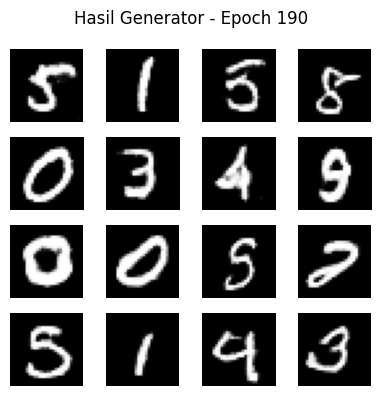

Epoch 191/1000 | noise_std=0.081 | gen_loss=0.8068 | disc_loss=1.3729 | 9.0s
Epoch 192/1000 | noise_std=0.081 | gen_loss=0.8061 | disc_loss=1.3735 | 9.0s
Epoch 193/1000 | noise_std=0.081 | gen_loss=0.8059 | disc_loss=1.3733 | 9.0s
Epoch 194/1000 | noise_std=0.081 | gen_loss=0.8057 | disc_loss=1.3739 | 9.0s
Epoch 195/1000 | noise_std=0.081 | gen_loss=0.8072 | disc_loss=1.3728 | 9.0s
Epoch 196/1000 | noise_std=0.080 | gen_loss=0.8057 | disc_loss=1.3737 | 9.0s


E0000 00:00:1767417165.489009      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 197/1000 | noise_std=0.080 | gen_loss=0.8061 | disc_loss=1.3733 | 9.0s
Epoch 198/1000 | noise_std=0.080 | gen_loss=0.8062 | disc_loss=1.3727 | 8.9s
Epoch 199/1000 | noise_std=0.080 | gen_loss=0.8059 | disc_loss=1.3734 | 9.0s
Epoch 200/1000 | noise_std=0.080 | gen_loss=0.8058 | disc_loss=1.3736 | 9.0s


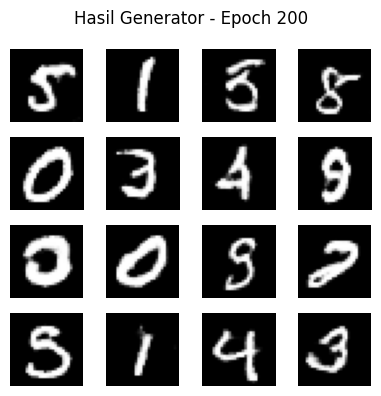

Epoch 201/1000 | noise_std=0.080 | gen_loss=0.8054 | disc_loss=1.3738 | 9.0s
Epoch 202/1000 | noise_std=0.080 | gen_loss=0.8057 | disc_loss=1.3734 | 9.0s
Epoch 203/1000 | noise_std=0.080 | gen_loss=0.8054 | disc_loss=1.3737 | 9.0s


E0000 00:00:1767417228.639376      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 204/1000 | noise_std=0.080 | gen_loss=0.8055 | disc_loss=1.3740 | 9.0s
Epoch 205/1000 | noise_std=0.080 | gen_loss=0.8054 | disc_loss=1.3736 | 9.0s
Epoch 206/1000 | noise_std=0.079 | gen_loss=0.8053 | disc_loss=1.3744 | 9.0s
Epoch 207/1000 | noise_std=0.079 | gen_loss=0.8051 | disc_loss=1.3736 | 9.0s
Epoch 208/1000 | noise_std=0.079 | gen_loss=0.8053 | disc_loss=1.3741 | 9.0s
Epoch 209/1000 | noise_std=0.079 | gen_loss=0.8053 | disc_loss=1.3737 | 9.0s
Epoch 210/1000 | noise_std=0.079 | gen_loss=0.8051 | disc_loss=1.3737 | 9.0s


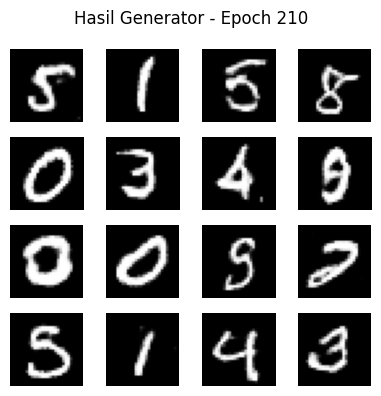

E0000 00:00:1767417291.719023      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 211/1000 | noise_std=0.079 | gen_loss=0.8049 | disc_loss=1.3741 | 9.0s
Epoch 212/1000 | noise_std=0.079 | gen_loss=0.8053 | disc_loss=1.3736 | 9.0s
Epoch 213/1000 | noise_std=0.079 | gen_loss=0.8047 | disc_loss=1.3742 | 9.0s
Epoch 214/1000 | noise_std=0.079 | gen_loss=0.8047 | disc_loss=1.3744 | 9.0s
Epoch 215/1000 | noise_std=0.079 | gen_loss=0.8043 | disc_loss=1.3746 | 9.0s
Epoch 216/1000 | noise_std=0.078 | gen_loss=0.8048 | disc_loss=1.3739 | 9.0s
Epoch 217/1000 | noise_std=0.078 | gen_loss=0.8048 | disc_loss=1.3739 | 9.0s


E0000 00:00:1767417354.589255      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 218/1000 | noise_std=0.078 | gen_loss=0.8040 | disc_loss=1.3745 | 9.0s
Epoch 219/1000 | noise_std=0.078 | gen_loss=0.8046 | disc_loss=1.3742 | 9.0s
Epoch 220/1000 | noise_std=0.078 | gen_loss=0.8047 | disc_loss=1.3740 | 9.0s


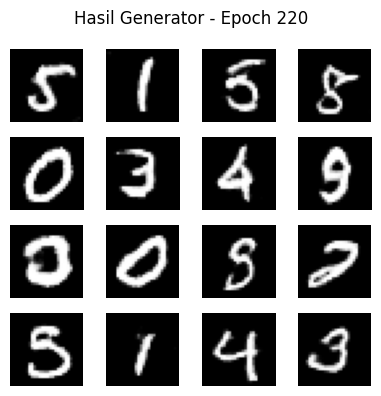

Epoch 221/1000 | noise_std=0.078 | gen_loss=0.8046 | disc_loss=1.3743 | 9.0s
Epoch 222/1000 | noise_std=0.078 | gen_loss=0.8043 | disc_loss=1.3741 | 9.0s
Epoch 223/1000 | noise_std=0.078 | gen_loss=0.8054 | disc_loss=1.3734 | 9.0s
Epoch 224/1000 | noise_std=0.078 | gen_loss=0.8043 | disc_loss=1.3742 | 9.0s


E0000 00:00:1767417417.613101      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 225/1000 | noise_std=0.078 | gen_loss=0.8044 | disc_loss=1.3746 | 9.0s
Epoch 226/1000 | noise_std=0.077 | gen_loss=0.8049 | disc_loss=1.3736 | 9.0s
Epoch 227/1000 | noise_std=0.077 | gen_loss=0.8040 | disc_loss=1.3746 | 9.0s
Epoch 228/1000 | noise_std=0.077 | gen_loss=0.8045 | disc_loss=1.3739 | 9.0s
Epoch 229/1000 | noise_std=0.077 | gen_loss=0.8048 | disc_loss=1.3737 | 9.0s
Epoch 230/1000 | noise_std=0.077 | gen_loss=0.8039 | disc_loss=1.3744 | 9.1s


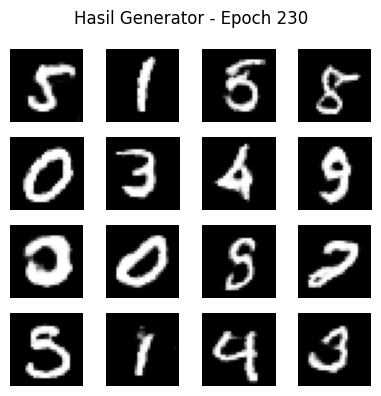

Epoch 231/1000 | noise_std=0.077 | gen_loss=0.8047 | disc_loss=1.3739 | 10.6s


E0000 00:00:1767417482.504037      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 232/1000 | noise_std=0.077 | gen_loss=0.8041 | disc_loss=1.3744 | 9.0s
Epoch 233/1000 | noise_std=0.077 | gen_loss=0.8040 | disc_loss=1.3745 | 9.0s
Epoch 234/1000 | noise_std=0.077 | gen_loss=0.8039 | disc_loss=1.3746 | 9.0s
Epoch 235/1000 | noise_std=0.077 | gen_loss=0.8038 | disc_loss=1.3747 | 9.0s
Epoch 236/1000 | noise_std=0.076 | gen_loss=0.8041 | disc_loss=1.3742 | 9.0s
Epoch 237/1000 | noise_std=0.076 | gen_loss=0.8044 | disc_loss=1.3743 | 9.0s
Epoch 238/1000 | noise_std=0.076 | gen_loss=0.8036 | disc_loss=1.3748 | 9.0s


E0000 00:00:1767417545.377656      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 239/1000 | noise_std=0.076 | gen_loss=0.8035 | disc_loss=1.3746 | 9.0s
Epoch 240/1000 | noise_std=0.076 | gen_loss=0.8036 | disc_loss=1.3746 | 9.0s


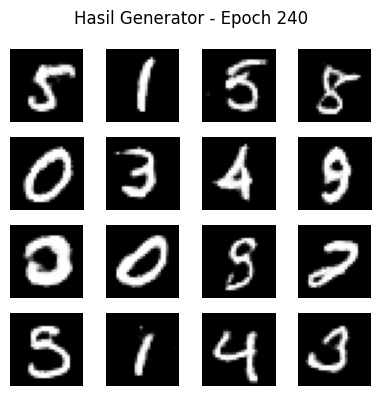

Epoch 241/1000 | noise_std=0.076 | gen_loss=0.8037 | disc_loss=1.3745 | 9.0s
Epoch 242/1000 | noise_std=0.076 | gen_loss=0.8042 | disc_loss=1.3741 | 9.0s
Epoch 243/1000 | noise_std=0.076 | gen_loss=0.8032 | disc_loss=1.3747 | 9.0s
Epoch 244/1000 | noise_std=0.076 | gen_loss=0.8038 | disc_loss=1.3747 | 9.0s
Epoch 245/1000 | noise_std=0.076 | gen_loss=0.8036 | disc_loss=1.3745 | 9.0s


E0000 00:00:1767417608.433074      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 246/1000 | noise_std=0.075 | gen_loss=0.8039 | disc_loss=1.3743 | 9.0s
Epoch 247/1000 | noise_std=0.075 | gen_loss=0.8037 | disc_loss=1.3744 | 9.0s
Epoch 248/1000 | noise_std=0.075 | gen_loss=0.8040 | disc_loss=1.3741 | 9.0s
Epoch 249/1000 | noise_std=0.075 | gen_loss=0.8034 | disc_loss=1.3747 | 9.0s
Epoch 250/1000 | noise_std=0.075 | gen_loss=0.8034 | disc_loss=1.3748 | 9.0s


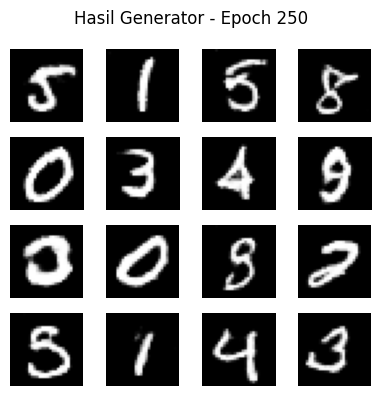

Epoch 251/1000 | noise_std=0.075 | gen_loss=0.8035 | disc_loss=1.3746 | 9.0s
Epoch 252/1000 | noise_std=0.075 | gen_loss=0.8029 | disc_loss=1.3751 | 9.0s


E0000 00:00:1767417671.562356      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 253/1000 | noise_std=0.075 | gen_loss=0.8036 | disc_loss=1.3744 | 9.0s
Epoch 254/1000 | noise_std=0.075 | gen_loss=0.8032 | disc_loss=1.3750 | 9.0s
Epoch 255/1000 | noise_std=0.075 | gen_loss=0.8029 | disc_loss=1.3750 | 9.0s
Epoch 256/1000 | noise_std=0.074 | gen_loss=0.8036 | disc_loss=1.3748 | 9.0s
Epoch 257/1000 | noise_std=0.074 | gen_loss=0.8035 | disc_loss=1.3744 | 9.0s
Epoch 258/1000 | noise_std=0.074 | gen_loss=0.8032 | disc_loss=1.3748 | 9.0s
Epoch 259/1000 | noise_std=0.074 | gen_loss=0.8028 | disc_loss=1.3750 | 9.0s


E0000 00:00:1767417734.438343      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 260/1000 | noise_std=0.074 | gen_loss=0.8027 | disc_loss=1.3753 | 9.0s


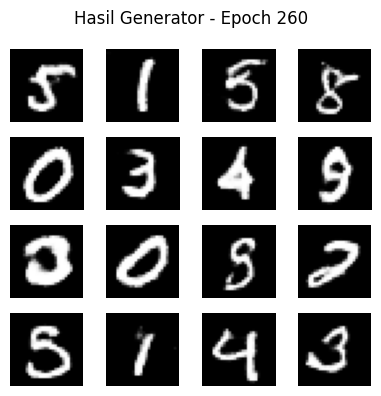

Epoch 261/1000 | noise_std=0.074 | gen_loss=0.8032 | disc_loss=1.3745 | 9.0s
Epoch 262/1000 | noise_std=0.074 | gen_loss=0.8034 | disc_loss=1.3745 | 9.0s
Epoch 263/1000 | noise_std=0.074 | gen_loss=0.8036 | disc_loss=1.3748 | 9.0s
Epoch 264/1000 | noise_std=0.074 | gen_loss=0.8029 | disc_loss=1.3748 | 9.0s
Epoch 265/1000 | noise_std=0.074 | gen_loss=0.8028 | disc_loss=1.3752 | 9.0s
Epoch 266/1000 | noise_std=0.073 | gen_loss=0.8030 | disc_loss=1.3750 | 9.0s


E0000 00:00:1767417797.514672      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 267/1000 | noise_std=0.073 | gen_loss=0.8026 | disc_loss=1.3750 | 9.0s
Epoch 268/1000 | noise_std=0.073 | gen_loss=0.8028 | disc_loss=1.3748 | 9.0s
Epoch 269/1000 | noise_std=0.073 | gen_loss=0.8031 | disc_loss=1.3746 | 9.0s
Epoch 270/1000 | noise_std=0.073 | gen_loss=0.8028 | disc_loss=1.3753 | 9.0s


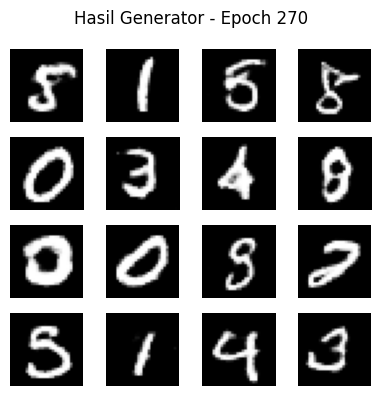

Epoch 271/1000 | noise_std=0.073 | gen_loss=0.8025 | disc_loss=1.3750 | 9.0s
Epoch 272/1000 | noise_std=0.073 | gen_loss=0.8032 | disc_loss=1.3751 | 9.0s
Epoch 273/1000 | noise_std=0.073 | gen_loss=0.8025 | disc_loss=1.3749 | 9.0s


E0000 00:00:1767417860.658751      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 274/1000 | noise_std=0.073 | gen_loss=0.8025 | disc_loss=1.3751 | 9.0s
Epoch 275/1000 | noise_std=0.073 | gen_loss=0.8025 | disc_loss=1.3754 | 9.0s
Epoch 276/1000 | noise_std=0.072 | gen_loss=0.8031 | disc_loss=1.3749 | 9.0s
Epoch 277/1000 | noise_std=0.072 | gen_loss=0.8028 | disc_loss=1.3750 | 9.0s
Epoch 278/1000 | noise_std=0.072 | gen_loss=0.8023 | disc_loss=1.3751 | 9.0s
Epoch 279/1000 | noise_std=0.072 | gen_loss=0.8023 | disc_loss=1.3754 | 9.0s
Epoch 280/1000 | noise_std=0.072 | gen_loss=0.8029 | disc_loss=1.3750 | 9.0s


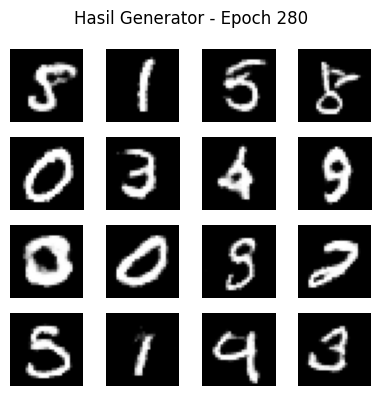

E0000 00:00:1767417923.750629      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 281/1000 | noise_std=0.072 | gen_loss=0.8026 | disc_loss=1.3749 | 9.0s
Epoch 282/1000 | noise_std=0.072 | gen_loss=0.8026 | disc_loss=1.3748 | 9.0s
Epoch 283/1000 | noise_std=0.072 | gen_loss=0.8036 | disc_loss=1.3743 | 9.0s
Epoch 284/1000 | noise_std=0.072 | gen_loss=0.8022 | disc_loss=1.3753 | 9.0s
Epoch 285/1000 | noise_std=0.072 | gen_loss=0.8024 | disc_loss=1.3752 | 9.0s
Epoch 286/1000 | noise_std=0.071 | gen_loss=0.8019 | disc_loss=1.3755 | 9.0s
Epoch 287/1000 | noise_std=0.071 | gen_loss=0.8021 | disc_loss=1.3757 | 11.0s


E0000 00:00:1767417988.756318      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 288/1000 | noise_std=0.071 | gen_loss=0.8019 | disc_loss=1.3755 | 9.0s
Epoch 289/1000 | noise_std=0.071 | gen_loss=0.8020 | disc_loss=1.3756 | 9.0s
Epoch 290/1000 | noise_std=0.071 | gen_loss=0.8024 | disc_loss=1.3750 | 9.0s


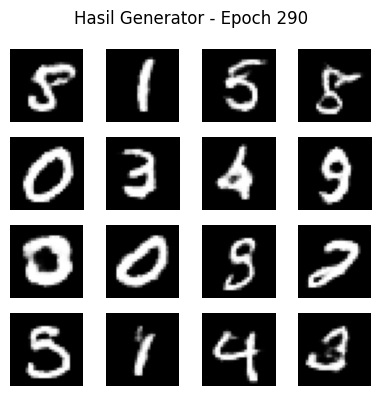

Epoch 291/1000 | noise_std=0.071 | gen_loss=0.8020 | disc_loss=1.3752 | 9.0s
Epoch 292/1000 | noise_std=0.071 | gen_loss=0.8022 | disc_loss=1.3754 | 9.0s
Epoch 293/1000 | noise_std=0.071 | gen_loss=0.8024 | disc_loss=1.3750 | 9.0s
Epoch 294/1000 | noise_std=0.071 | gen_loss=0.8030 | disc_loss=1.3748 | 9.0s


E0000 00:00:1767418051.940766      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 295/1000 | noise_std=0.071 | gen_loss=0.8026 | disc_loss=1.3752 | 9.0s
Epoch 296/1000 | noise_std=0.070 | gen_loss=0.8021 | disc_loss=1.3755 | 9.0s
Epoch 297/1000 | noise_std=0.070 | gen_loss=0.8021 | disc_loss=1.3749 | 9.0s
Epoch 298/1000 | noise_std=0.070 | gen_loss=0.8020 | disc_loss=1.3754 | 9.0s
Epoch 299/1000 | noise_std=0.070 | gen_loss=0.8018 | disc_loss=1.3755 | 9.0s
Epoch 300/1000 | noise_std=0.070 | gen_loss=0.8021 | disc_loss=1.3752 | 9.0s


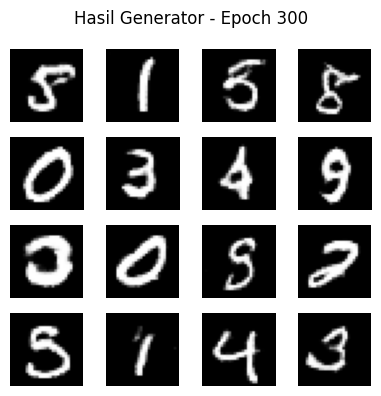

Epoch 301/1000 | noise_std=0.070 | gen_loss=0.8022 | disc_loss=1.3753 | 9.0s


E0000 00:00:1767418115.145711      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 302/1000 | noise_std=0.070 | gen_loss=0.8020 | disc_loss=1.3753 | 9.0s
Epoch 303/1000 | noise_std=0.070 | gen_loss=0.8022 | disc_loss=1.3751 | 9.0s
Epoch 304/1000 | noise_std=0.070 | gen_loss=0.8018 | disc_loss=1.3756 | 9.0s
Epoch 305/1000 | noise_std=0.070 | gen_loss=0.8016 | disc_loss=1.3756 | 9.0s
Epoch 306/1000 | noise_std=0.069 | gen_loss=0.8017 | disc_loss=1.3755 | 9.0s
Epoch 307/1000 | noise_std=0.069 | gen_loss=0.8014 | disc_loss=1.3758 | 9.0s
Epoch 308/1000 | noise_std=0.069 | gen_loss=0.8020 | disc_loss=1.3753 | 9.0s


E0000 00:00:1767418178.234641      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 309/1000 | noise_std=0.069 | gen_loss=0.8026 | disc_loss=1.3748 | 9.0s
Epoch 310/1000 | noise_std=0.069 | gen_loss=0.8020 | disc_loss=1.3753 | 9.0s


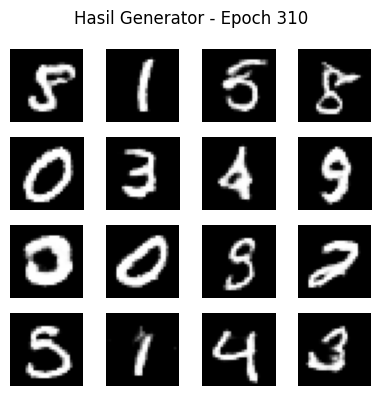

Epoch 311/1000 | noise_std=0.069 | gen_loss=0.8018 | disc_loss=1.3755 | 9.0s
Epoch 312/1000 | noise_std=0.069 | gen_loss=0.8017 | disc_loss=1.3754 | 9.0s
Epoch 313/1000 | noise_std=0.069 | gen_loss=0.8017 | disc_loss=1.3754 | 9.0s
Epoch 314/1000 | noise_std=0.069 | gen_loss=0.8018 | disc_loss=1.3756 | 9.0s
Epoch 315/1000 | noise_std=0.069 | gen_loss=0.8018 | disc_loss=1.3751 | 9.0s


E0000 00:00:1767418241.437113      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 316/1000 | noise_std=0.068 | gen_loss=0.8017 | disc_loss=1.3754 | 9.0s
Epoch 317/1000 | noise_std=0.068 | gen_loss=0.8018 | disc_loss=1.3755 | 9.0s
Epoch 318/1000 | noise_std=0.068 | gen_loss=0.8019 | disc_loss=1.3750 | 9.0s
Epoch 319/1000 | noise_std=0.068 | gen_loss=0.8014 | disc_loss=1.3756 | 9.0s
Epoch 320/1000 | noise_std=0.068 | gen_loss=0.8021 | disc_loss=1.3751 | 9.0s


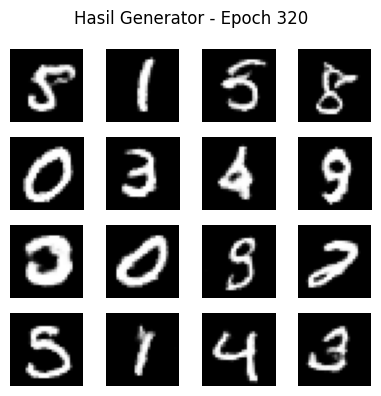

Epoch 321/1000 | noise_std=0.068 | gen_loss=0.8017 | disc_loss=1.3754 | 9.0s
Epoch 322/1000 | noise_std=0.068 | gen_loss=0.8018 | disc_loss=1.3756 | 9.0s


E0000 00:00:1767418304.700719      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 323/1000 | noise_std=0.068 | gen_loss=0.8014 | disc_loss=1.3757 | 9.0s
Epoch 324/1000 | noise_std=0.068 | gen_loss=0.8015 | disc_loss=1.3755 | 9.0s
Epoch 325/1000 | noise_std=0.068 | gen_loss=0.8014 | disc_loss=1.3755 | 9.0s
Epoch 326/1000 | noise_std=0.067 | gen_loss=0.8018 | disc_loss=1.3753 | 9.0s
Epoch 327/1000 | noise_std=0.067 | gen_loss=0.8019 | disc_loss=1.3751 | 9.0s
Epoch 328/1000 | noise_std=0.067 | gen_loss=0.8017 | disc_loss=1.3754 | 9.0s
Epoch 329/1000 | noise_std=0.067 | gen_loss=0.8018 | disc_loss=1.3749 | 9.0s


E0000 00:00:1767418367.775695      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 330/1000 | noise_std=0.067 | gen_loss=0.8016 | disc_loss=1.3757 | 9.0s


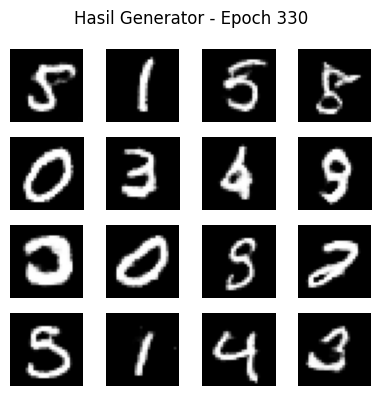

Epoch 331/1000 | noise_std=0.067 | gen_loss=0.8019 | disc_loss=1.3757 | 9.0s
Epoch 332/1000 | noise_std=0.067 | gen_loss=0.8017 | disc_loss=1.3751 | 9.0s
Epoch 333/1000 | noise_std=0.067 | gen_loss=0.8014 | disc_loss=1.3758 | 9.0s
Epoch 334/1000 | noise_std=0.067 | gen_loss=0.8010 | disc_loss=1.3758 | 9.0s
Epoch 335/1000 | noise_std=0.067 | gen_loss=0.8016 | disc_loss=1.3753 | 9.0s
Epoch 336/1000 | noise_std=0.066 | gen_loss=0.8014 | disc_loss=1.3753 | 9.0s


E0000 00:00:1767418431.098867      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 337/1000 | noise_std=0.066 | gen_loss=0.8016 | disc_loss=1.3755 | 9.0s
Epoch 338/1000 | noise_std=0.066 | gen_loss=0.8013 | disc_loss=1.3755 | 9.0s
Epoch 339/1000 | noise_std=0.066 | gen_loss=0.8015 | disc_loss=1.3756 | 9.0s
Epoch 340/1000 | noise_std=0.066 | gen_loss=0.8014 | disc_loss=1.3756 | 9.0s


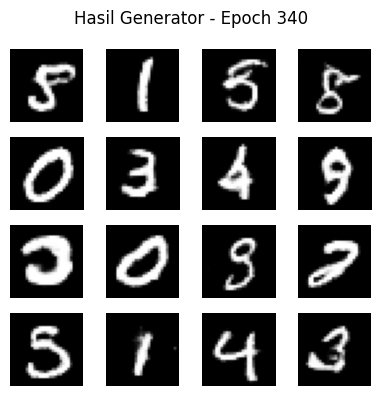

Epoch 341/1000 | noise_std=0.066 | gen_loss=0.8019 | disc_loss=1.3754 | 9.0s
Epoch 342/1000 | noise_std=0.066 | gen_loss=0.8015 | disc_loss=1.3754 | 9.0s
Epoch 343/1000 | noise_std=0.066 | gen_loss=0.8014 | disc_loss=1.3756 | 9.0s


E0000 00:00:1767418494.369322      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 344/1000 | noise_std=0.066 | gen_loss=0.8014 | disc_loss=1.3753 | 9.0s
Epoch 345/1000 | noise_std=0.066 | gen_loss=0.8017 | disc_loss=1.3755 | 9.0s
Epoch 346/1000 | noise_std=0.065 | gen_loss=0.8011 | disc_loss=1.3757 | 9.0s
Epoch 347/1000 | noise_std=0.065 | gen_loss=0.8015 | disc_loss=1.3753 | 9.0s
Epoch 348/1000 | noise_std=0.065 | gen_loss=0.8010 | disc_loss=1.3758 | 9.1s
Epoch 349/1000 | noise_std=0.065 | gen_loss=0.8020 | disc_loss=1.3752 | 9.0s
Epoch 350/1000 | noise_std=0.065 | gen_loss=0.8013 | disc_loss=1.3753 | 9.0s


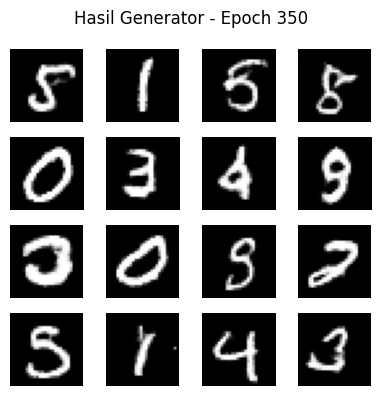

E0000 00:00:1767418557.710468      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 351/1000 | noise_std=0.065 | gen_loss=0.8017 | disc_loss=1.3752 | 9.1s
Epoch 352/1000 | noise_std=0.065 | gen_loss=0.8015 | disc_loss=1.3752 | 11.4s
Epoch 353/1000 | noise_std=0.065 | gen_loss=0.8013 | disc_loss=1.3755 | 9.0s
Epoch 354/1000 | noise_std=0.065 | gen_loss=0.8015 | disc_loss=1.3756 | 9.0s
Epoch 355/1000 | noise_std=0.065 | gen_loss=0.8012 | disc_loss=1.3756 | 9.0s
Epoch 356/1000 | noise_std=0.064 | gen_loss=0.8011 | disc_loss=1.3755 | 9.0s
Epoch 357/1000 | noise_std=0.064 | gen_loss=0.8013 | disc_loss=1.3755 | 9.0s


E0000 00:00:1767418623.197850      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 358/1000 | noise_std=0.064 | gen_loss=0.8012 | disc_loss=1.3760 | 9.0s
Epoch 359/1000 | noise_std=0.064 | gen_loss=0.8014 | disc_loss=1.3757 | 9.0s
Epoch 360/1000 | noise_std=0.064 | gen_loss=0.8010 | disc_loss=1.3760 | 9.0s


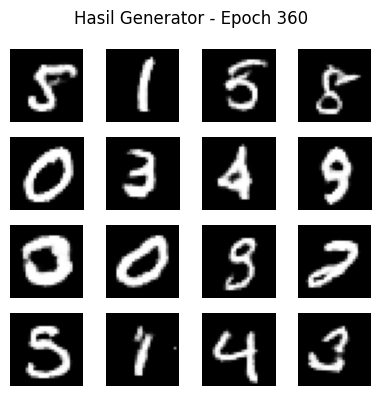

Epoch 361/1000 | noise_std=0.064 | gen_loss=0.8009 | disc_loss=1.3758 | 9.1s
Epoch 362/1000 | noise_std=0.064 | gen_loss=0.8008 | disc_loss=1.3758 | 9.1s
Epoch 363/1000 | noise_std=0.064 | gen_loss=0.8011 | disc_loss=1.3756 | 9.0s
Epoch 364/1000 | noise_std=0.064 | gen_loss=0.8009 | disc_loss=1.3759 | 9.0s


E0000 00:00:1767418686.605165      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 365/1000 | noise_std=0.064 | gen_loss=0.8009 | disc_loss=1.3759 | 9.0s
Epoch 366/1000 | noise_std=0.063 | gen_loss=0.8013 | disc_loss=1.3755 | 9.0s
Epoch 367/1000 | noise_std=0.063 | gen_loss=0.8009 | disc_loss=1.3759 | 9.0s
Epoch 368/1000 | noise_std=0.063 | gen_loss=0.8008 | disc_loss=1.3758 | 9.0s
Epoch 369/1000 | noise_std=0.063 | gen_loss=0.8011 | disc_loss=1.3756 | 9.0s
Epoch 370/1000 | noise_std=0.063 | gen_loss=0.8007 | disc_loss=1.3757 | 9.0s


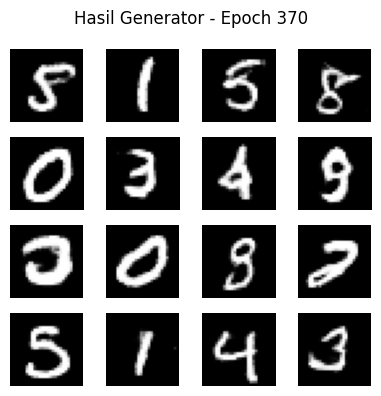

Epoch 371/1000 | noise_std=0.063 | gen_loss=0.8008 | disc_loss=1.3761 | 9.0s


E0000 00:00:1767418749.980512      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 372/1000 | noise_std=0.063 | gen_loss=0.8007 | disc_loss=1.3759 | 9.1s
Epoch 373/1000 | noise_std=0.063 | gen_loss=0.8012 | disc_loss=1.3756 | 9.0s
Epoch 374/1000 | noise_std=0.063 | gen_loss=0.8007 | disc_loss=1.3757 | 9.0s
Epoch 375/1000 | noise_std=0.063 | gen_loss=0.8012 | disc_loss=1.3754 | 9.1s
Epoch 376/1000 | noise_std=0.062 | gen_loss=0.8011 | disc_loss=1.3758 | 9.1s
Epoch 377/1000 | noise_std=0.062 | gen_loss=0.8010 | disc_loss=1.3757 | 9.0s
Epoch 378/1000 | noise_std=0.062 | gen_loss=0.8008 | disc_loss=1.3757 | 9.0s


E0000 00:00:1767418813.238265      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 379/1000 | noise_std=0.062 | gen_loss=0.8008 | disc_loss=1.3757 | 9.0s
Epoch 380/1000 | noise_std=0.062 | gen_loss=0.8008 | disc_loss=1.3760 | 9.0s


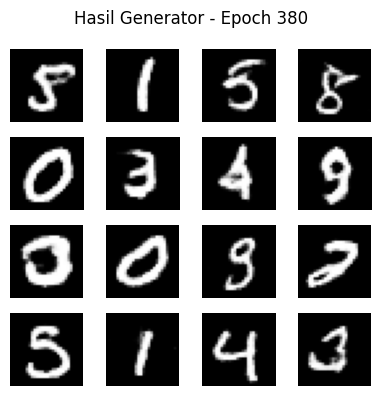

Epoch 381/1000 | noise_std=0.062 | gen_loss=0.8008 | disc_loss=1.3757 | 9.0s
Epoch 382/1000 | noise_std=0.062 | gen_loss=0.8007 | disc_loss=1.3761 | 9.0s
Epoch 383/1000 | noise_std=0.062 | gen_loss=0.8003 | disc_loss=1.3760 | 9.0s
Epoch 384/1000 | noise_std=0.062 | gen_loss=0.8007 | disc_loss=1.3757 | 9.0s
Epoch 385/1000 | noise_std=0.062 | gen_loss=0.8010 | disc_loss=1.3757 | 9.0s


E0000 00:00:1767418876.676423      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 386/1000 | noise_std=0.061 | gen_loss=0.8009 | disc_loss=1.3759 | 9.0s
Epoch 387/1000 | noise_std=0.061 | gen_loss=0.8007 | disc_loss=1.3758 | 9.0s
Epoch 388/1000 | noise_std=0.061 | gen_loss=0.8008 | disc_loss=1.3758 | 9.0s
Epoch 389/1000 | noise_std=0.061 | gen_loss=0.8007 | disc_loss=1.3759 | 9.0s
Epoch 390/1000 | noise_std=0.061 | gen_loss=0.8004 | disc_loss=1.3761 | 9.0s


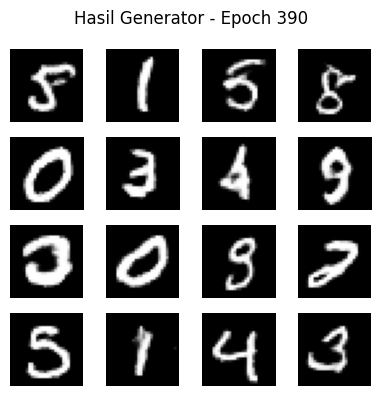

Epoch 391/1000 | noise_std=0.061 | gen_loss=0.8006 | disc_loss=1.3759 | 9.0s
Epoch 392/1000 | noise_std=0.061 | gen_loss=0.8007 | disc_loss=1.3757 | 9.0s


E0000 00:00:1767418940.117983      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 393/1000 | noise_std=0.061 | gen_loss=0.8004 | disc_loss=1.3761 | 9.0s
Epoch 394/1000 | noise_std=0.061 | gen_loss=0.8006 | disc_loss=1.3759 | 9.0s
Epoch 395/1000 | noise_std=0.061 | gen_loss=0.8004 | disc_loss=1.3760 | 9.0s
Epoch 396/1000 | noise_std=0.060 | gen_loss=0.8007 | disc_loss=1.3755 | 9.0s
Epoch 397/1000 | noise_std=0.060 | gen_loss=0.8015 | disc_loss=1.3754 | 9.0s
Epoch 398/1000 | noise_std=0.060 | gen_loss=0.8008 | disc_loss=1.3760 | 9.0s
Epoch 399/1000 | noise_std=0.060 | gen_loss=0.8003 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767419003.229613      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 400/1000 | noise_std=0.060 | gen_loss=0.8005 | disc_loss=1.3759 | 9.0s


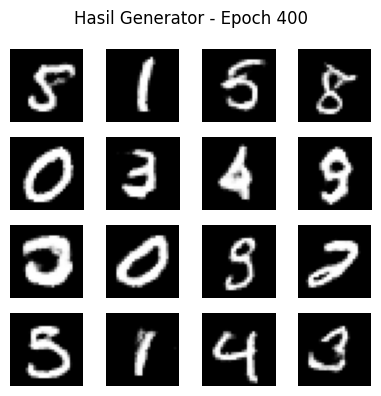

Epoch 401/1000 | noise_std=0.060 | gen_loss=0.8006 | disc_loss=1.3758 | 9.0s
Epoch 402/1000 | noise_std=0.060 | gen_loss=0.8005 | disc_loss=1.3758 | 9.0s
Epoch 403/1000 | noise_std=0.060 | gen_loss=0.8008 | disc_loss=1.3761 | 9.0s
Epoch 404/1000 | noise_std=0.060 | gen_loss=0.8002 | disc_loss=1.3760 | 9.1s
Epoch 405/1000 | noise_std=0.060 | gen_loss=0.8004 | disc_loss=1.3763 | 9.0s
Epoch 406/1000 | noise_std=0.059 | gen_loss=0.8008 | disc_loss=1.3761 | 9.0s


E0000 00:00:1767419066.615675      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 407/1000 | noise_std=0.059 | gen_loss=0.8002 | disc_loss=1.3759 | 9.0s
Epoch 408/1000 | noise_std=0.059 | gen_loss=0.8004 | disc_loss=1.3758 | 9.0s
Epoch 409/1000 | noise_std=0.059 | gen_loss=0.8003 | disc_loss=1.3761 | 9.0s
Epoch 410/1000 | noise_std=0.059 | gen_loss=0.8004 | disc_loss=1.3761 | 9.0s


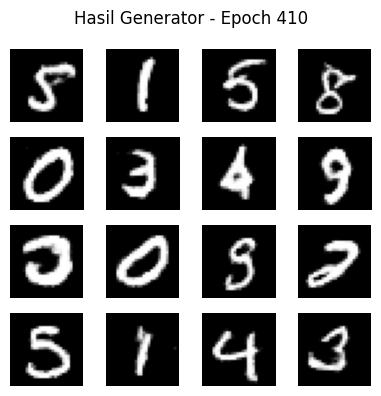

Epoch 411/1000 | noise_std=0.059 | gen_loss=0.8001 | disc_loss=1.3760 | 9.0s
Epoch 412/1000 | noise_std=0.059 | gen_loss=0.8008 | disc_loss=1.3757 | 9.0s
Epoch 413/1000 | noise_std=0.059 | gen_loss=0.8004 | disc_loss=1.3762 | 9.0s


E0000 00:00:1767419130.113326      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 414/1000 | noise_std=0.059 | gen_loss=0.8001 | disc_loss=1.3762 | 9.1s
Epoch 415/1000 | noise_std=0.059 | gen_loss=0.8001 | disc_loss=1.3763 | 9.0s
Epoch 416/1000 | noise_std=0.058 | gen_loss=0.8002 | disc_loss=1.3760 | 9.0s
Epoch 417/1000 | noise_std=0.058 | gen_loss=0.8004 | disc_loss=1.3758 | 9.1s
Epoch 418/1000 | noise_std=0.058 | gen_loss=0.8003 | disc_loss=1.3762 | 9.0s
Epoch 419/1000 | noise_std=0.058 | gen_loss=0.8002 | disc_loss=1.3758 | 9.0s
Epoch 420/1000 | noise_std=0.058 | gen_loss=0.8006 | disc_loss=1.3762 | 9.0s


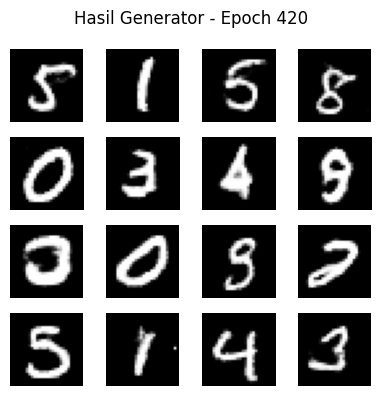

E0000 00:00:1767419193.496021      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 421/1000 | noise_std=0.058 | gen_loss=0.8001 | disc_loss=1.3760 | 9.0s
Epoch 422/1000 | noise_std=0.058 | gen_loss=0.8000 | disc_loss=1.3759 | 9.0s
Epoch 423/1000 | noise_std=0.058 | gen_loss=0.8002 | disc_loss=1.3760 | 9.1s
Epoch 424/1000 | noise_std=0.058 | gen_loss=0.8003 | disc_loss=1.3763 | 9.1s
Epoch 425/1000 | noise_std=0.058 | gen_loss=0.8002 | disc_loss=1.3763 | 9.1s
Epoch 426/1000 | noise_std=0.057 | gen_loss=0.8002 | disc_loss=1.3758 | 9.0s
Epoch 427/1000 | noise_std=0.057 | gen_loss=0.7999 | disc_loss=1.3762 | 9.1s


E0000 00:00:1767419256.829803      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 428/1000 | noise_std=0.057 | gen_loss=0.8004 | disc_loss=1.3760 | 9.0s
Epoch 429/1000 | noise_std=0.057 | gen_loss=0.8002 | disc_loss=1.3761 | 9.0s
Epoch 430/1000 | noise_std=0.057 | gen_loss=0.8001 | disc_loss=1.3761 | 9.0s


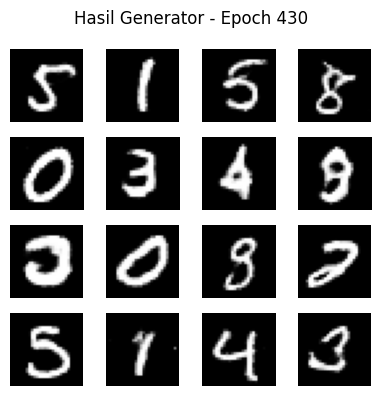

Epoch 431/1000 | noise_std=0.057 | gen_loss=0.8003 | disc_loss=1.3758 | 9.1s
Epoch 432/1000 | noise_std=0.057 | gen_loss=0.8001 | disc_loss=1.3761 | 9.0s
Epoch 433/1000 | noise_std=0.057 | gen_loss=0.8000 | disc_loss=1.3762 | 9.0s
Epoch 434/1000 | noise_std=0.057 | gen_loss=0.8000 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767419323.249586      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 435/1000 | noise_std=0.057 | gen_loss=0.8000 | disc_loss=1.3759 | 9.0s
Epoch 436/1000 | noise_std=0.056 | gen_loss=0.8003 | disc_loss=1.3760 | 9.0s
Epoch 437/1000 | noise_std=0.056 | gen_loss=0.8003 | disc_loss=1.3760 | 9.0s
Epoch 438/1000 | noise_std=0.056 | gen_loss=0.7998 | disc_loss=1.3762 | 9.1s
Epoch 439/1000 | noise_std=0.056 | gen_loss=0.8003 | disc_loss=1.3759 | 9.0s
Epoch 440/1000 | noise_std=0.056 | gen_loss=0.7997 | disc_loss=1.3764 | 9.2s


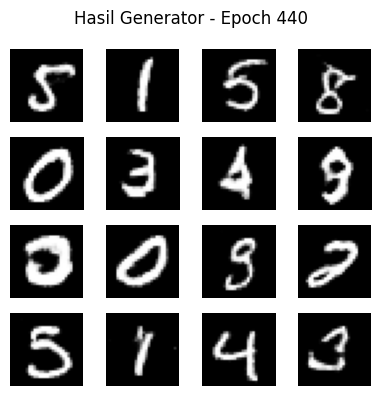

Epoch 441/1000 | noise_std=0.056 | gen_loss=0.8005 | disc_loss=1.3759 | 9.1s


E0000 00:00:1767419386.911468      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 442/1000 | noise_std=0.056 | gen_loss=0.8001 | disc_loss=1.3759 | 9.0s
Epoch 443/1000 | noise_std=0.056 | gen_loss=0.8000 | disc_loss=1.3764 | 9.1s
Epoch 444/1000 | noise_std=0.056 | gen_loss=0.8001 | disc_loss=1.3763 | 9.0s
Epoch 445/1000 | noise_std=0.056 | gen_loss=0.8002 | disc_loss=1.3759 | 9.0s
Epoch 446/1000 | noise_std=0.055 | gen_loss=0.7999 | disc_loss=1.3763 | 9.0s
Epoch 447/1000 | noise_std=0.055 | gen_loss=0.8001 | disc_loss=1.3759 | 9.0s
Epoch 448/1000 | noise_std=0.055 | gen_loss=0.8001 | disc_loss=1.3759 | 9.1s


E0000 00:00:1767419450.252485      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 449/1000 | noise_std=0.055 | gen_loss=0.7999 | disc_loss=1.3762 | 9.1s
Epoch 450/1000 | noise_std=0.055 | gen_loss=0.8000 | disc_loss=1.3761 | 9.0s


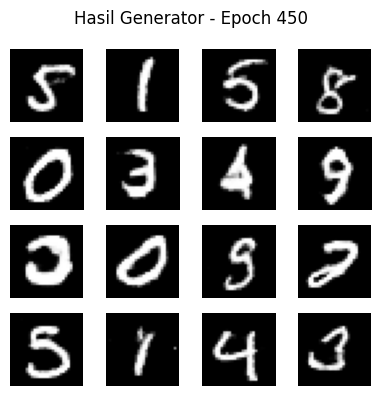

Epoch 451/1000 | noise_std=0.055 | gen_loss=0.8000 | disc_loss=1.3763 | 9.0s
Epoch 452/1000 | noise_std=0.055 | gen_loss=0.8000 | disc_loss=1.3761 | 9.0s
Epoch 453/1000 | noise_std=0.055 | gen_loss=0.7999 | disc_loss=1.3762 | 9.0s
Epoch 454/1000 | noise_std=0.055 | gen_loss=0.7998 | disc_loss=1.3762 | 9.1s
Epoch 455/1000 | noise_std=0.055 | gen_loss=0.8004 | disc_loss=1.3757 | 9.0s


E0000 00:00:1767419513.714535      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 456/1000 | noise_std=0.054 | gen_loss=0.7999 | disc_loss=1.3762 | 9.0s
Epoch 457/1000 | noise_std=0.054 | gen_loss=0.8000 | disc_loss=1.3760 | 9.0s
Epoch 458/1000 | noise_std=0.054 | gen_loss=0.8002 | disc_loss=1.3760 | 9.1s
Epoch 459/1000 | noise_std=0.054 | gen_loss=0.7999 | disc_loss=1.3761 | 9.0s
Epoch 460/1000 | noise_std=0.054 | gen_loss=0.8000 | disc_loss=1.3763 | 9.1s


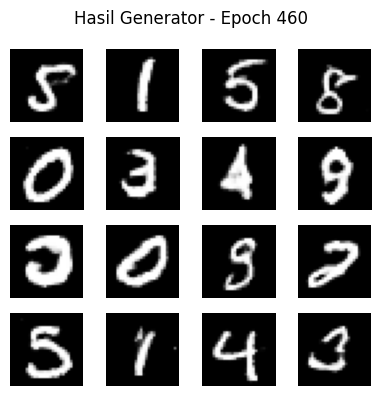

Epoch 461/1000 | noise_std=0.054 | gen_loss=0.8000 | disc_loss=1.3761 | 9.0s
Epoch 462/1000 | noise_std=0.054 | gen_loss=0.7994 | disc_loss=1.3766 | 9.0s


E0000 00:00:1767419577.253174      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 463/1000 | noise_std=0.054 | gen_loss=0.7995 | disc_loss=1.3765 | 9.0s
Epoch 464/1000 | noise_std=0.054 | gen_loss=0.7998 | disc_loss=1.3762 | 9.0s
Epoch 465/1000 | noise_std=0.054 | gen_loss=0.8002 | disc_loss=1.3761 | 9.0s
Epoch 466/1000 | noise_std=0.053 | gen_loss=0.8002 | disc_loss=1.3761 | 9.0s
Epoch 467/1000 | noise_std=0.053 | gen_loss=0.7995 | disc_loss=1.3762 | 9.1s
Epoch 468/1000 | noise_std=0.053 | gen_loss=0.8002 | disc_loss=1.3763 | 9.0s
Epoch 469/1000 | noise_std=0.053 | gen_loss=0.7996 | disc_loss=1.3760 | 9.0s


E0000 00:00:1767419640.547493      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 470/1000 | noise_std=0.053 | gen_loss=0.7999 | disc_loss=1.3764 | 9.1s


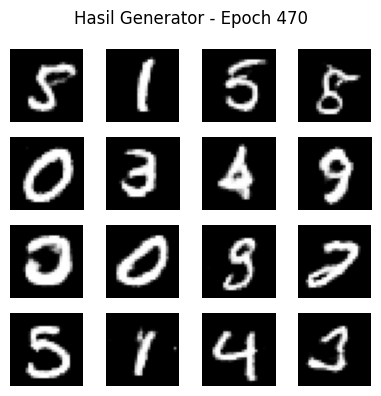

Epoch 471/1000 | noise_std=0.053 | gen_loss=0.7998 | disc_loss=1.3763 | 9.1s
Epoch 472/1000 | noise_std=0.053 | gen_loss=0.7996 | disc_loss=1.3765 | 9.1s
Epoch 473/1000 | noise_std=0.053 | gen_loss=0.7995 | disc_loss=1.3763 | 9.0s
Epoch 474/1000 | noise_std=0.053 | gen_loss=0.7999 | disc_loss=1.3764 | 9.0s
Epoch 475/1000 | noise_std=0.053 | gen_loss=0.7996 | disc_loss=1.3762 | 9.1s
Epoch 476/1000 | noise_std=0.052 | gen_loss=0.7997 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767419704.070050      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 477/1000 | noise_std=0.052 | gen_loss=0.8001 | disc_loss=1.3761 | 9.0s
Epoch 478/1000 | noise_std=0.052 | gen_loss=0.7998 | disc_loss=1.3762 | 9.0s
Epoch 479/1000 | noise_std=0.052 | gen_loss=0.7996 | disc_loss=1.3764 | 9.0s
Epoch 480/1000 | noise_std=0.052 | gen_loss=0.8000 | disc_loss=1.3760 | 9.0s


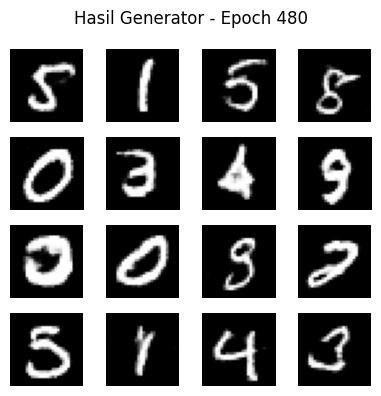

Epoch 481/1000 | noise_std=0.052 | gen_loss=0.7998 | disc_loss=1.3762 | 9.1s
Epoch 482/1000 | noise_std=0.052 | gen_loss=0.8001 | disc_loss=1.3761 | 9.1s
Epoch 483/1000 | noise_std=0.052 | gen_loss=0.7996 | disc_loss=1.3766 | 9.0s


E0000 00:00:1767419767.623322      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 484/1000 | noise_std=0.052 | gen_loss=0.7993 | disc_loss=1.3765 | 9.0s
Epoch 485/1000 | noise_std=0.052 | gen_loss=0.7998 | disc_loss=1.3762 | 9.0s
Epoch 486/1000 | noise_std=0.051 | gen_loss=0.7996 | disc_loss=1.3763 | 9.0s
Epoch 487/1000 | noise_std=0.051 | gen_loss=0.8001 | disc_loss=1.3760 | 9.0s
Epoch 488/1000 | noise_std=0.051 | gen_loss=0.7995 | disc_loss=1.3762 | 9.1s
Epoch 489/1000 | noise_std=0.051 | gen_loss=0.7996 | disc_loss=1.3763 | 9.1s
Epoch 490/1000 | noise_std=0.051 | gen_loss=0.7996 | disc_loss=1.3762 | 9.0s


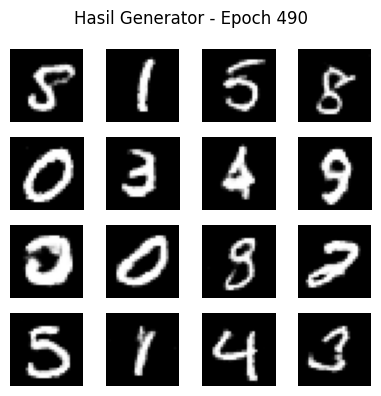

E0000 00:00:1767419831.160217      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 491/1000 | noise_std=0.051 | gen_loss=0.7998 | disc_loss=1.3764 | 9.0s
Epoch 492/1000 | noise_std=0.051 | gen_loss=0.7995 | disc_loss=1.3763 | 9.1s
Epoch 493/1000 | noise_std=0.051 | gen_loss=0.7994 | disc_loss=1.3765 | 9.0s
Epoch 494/1000 | noise_std=0.051 | gen_loss=0.7992 | disc_loss=1.3764 | 9.0s
Epoch 495/1000 | noise_std=0.051 | gen_loss=0.7997 | disc_loss=1.3763 | 9.0s
Epoch 496/1000 | noise_std=0.050 | gen_loss=0.7998 | disc_loss=1.3762 | 9.0s
Epoch 497/1000 | noise_std=0.050 | gen_loss=0.7997 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767419894.377080      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 498/1000 | noise_std=0.050 | gen_loss=0.7996 | disc_loss=1.3764 | 9.0s
Epoch 499/1000 | noise_std=0.050 | gen_loss=0.7990 | disc_loss=1.3765 | 9.0s
Epoch 500/1000 | noise_std=0.050 | gen_loss=0.7996 | disc_loss=1.3763 | 9.0s


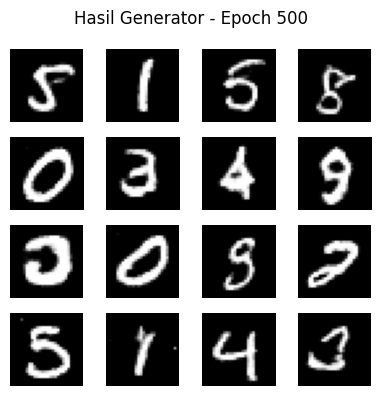

Epoch 501/1000 | noise_std=0.050 | gen_loss=0.7996 | disc_loss=1.3764 | 9.0s
Epoch 502/1000 | noise_std=0.050 | gen_loss=0.7991 | disc_loss=1.3767 | 9.0s
Epoch 503/1000 | noise_std=0.050 | gen_loss=0.7996 | disc_loss=1.3763 | 9.1s
Epoch 504/1000 | noise_std=0.050 | gen_loss=0.7996 | disc_loss=1.3764 | 9.0s


E0000 00:00:1767419957.908526      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 505/1000 | noise_std=0.050 | gen_loss=0.7996 | disc_loss=1.3761 | 9.0s
Epoch 506/1000 | noise_std=0.049 | gen_loss=0.7996 | disc_loss=1.3764 | 9.0s
Epoch 507/1000 | noise_std=0.049 | gen_loss=0.7997 | disc_loss=1.3762 | 9.0s
Epoch 508/1000 | noise_std=0.049 | gen_loss=0.7995 | disc_loss=1.3762 | 9.0s
Epoch 509/1000 | noise_std=0.049 | gen_loss=0.7992 | disc_loss=1.3766 | 9.0s
Epoch 510/1000 | noise_std=0.049 | gen_loss=0.7995 | disc_loss=1.3765 | 9.0s


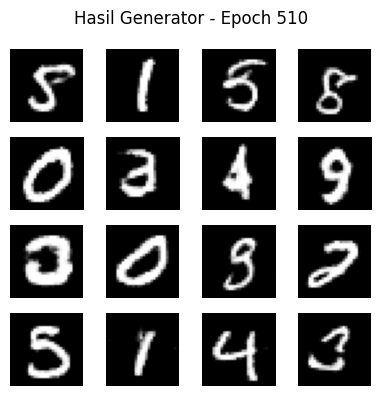

Epoch 511/1000 | noise_std=0.049 | gen_loss=0.7994 | disc_loss=1.3764 | 9.0s


E0000 00:00:1767420021.410659      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 512/1000 | noise_std=0.049 | gen_loss=0.7993 | disc_loss=1.3766 | 9.0s
Epoch 513/1000 | noise_std=0.049 | gen_loss=0.7993 | disc_loss=1.3763 | 9.1s
Epoch 514/1000 | noise_std=0.049 | gen_loss=0.7998 | disc_loss=1.3762 | 9.1s
Epoch 515/1000 | noise_std=0.049 | gen_loss=0.7993 | disc_loss=1.3763 | 9.0s
Epoch 516/1000 | noise_std=0.048 | gen_loss=0.7993 | disc_loss=1.3762 | 9.0s
Epoch 517/1000 | noise_std=0.048 | gen_loss=0.7994 | disc_loss=1.3763 | 9.1s
Epoch 518/1000 | noise_std=0.048 | gen_loss=0.7996 | disc_loss=1.3766 | 9.0s


E0000 00:00:1767420084.743771      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 519/1000 | noise_std=0.048 | gen_loss=0.7994 | disc_loss=1.3764 | 9.0s
Epoch 520/1000 | noise_std=0.048 | gen_loss=0.7999 | disc_loss=1.3761 | 9.0s


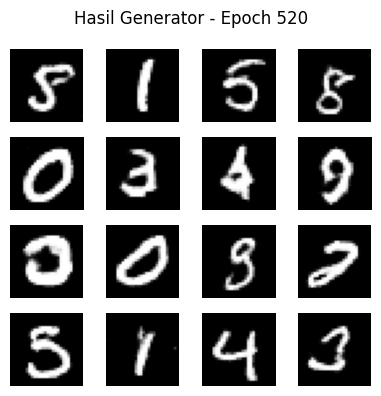

Epoch 521/1000 | noise_std=0.048 | gen_loss=0.7996 | disc_loss=1.3763 | 9.0s
Epoch 522/1000 | noise_std=0.048 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 523/1000 | noise_std=0.048 | gen_loss=0.7998 | disc_loss=1.3762 | 9.1s
Epoch 524/1000 | noise_std=0.048 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s
Epoch 525/1000 | noise_std=0.048 | gen_loss=0.7998 | disc_loss=1.3762 | 12.6s


E0000 00:00:1767420151.943251      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 526/1000 | noise_std=0.047 | gen_loss=0.7992 | disc_loss=1.3761 | 9.0s
Epoch 527/1000 | noise_std=0.047 | gen_loss=0.7995 | disc_loss=1.3764 | 9.0s
Epoch 528/1000 | noise_std=0.047 | gen_loss=0.7995 | disc_loss=1.3763 | 9.1s
Epoch 529/1000 | noise_std=0.047 | gen_loss=0.7997 | disc_loss=1.3762 | 9.1s
Epoch 530/1000 | noise_std=0.047 | gen_loss=0.7998 | disc_loss=1.3764 | 9.0s


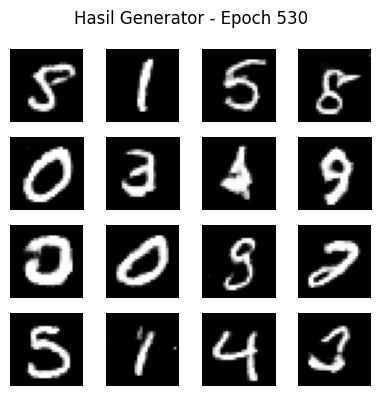

Epoch 531/1000 | noise_std=0.047 | gen_loss=0.7994 | disc_loss=1.3764 | 9.0s
Epoch 532/1000 | noise_std=0.047 | gen_loss=0.7994 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767420215.515272      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 533/1000 | noise_std=0.047 | gen_loss=0.7994 | disc_loss=1.3762 | 9.1s
Epoch 534/1000 | noise_std=0.047 | gen_loss=0.8004 | disc_loss=1.3761 | 9.0s
Epoch 535/1000 | noise_std=0.047 | gen_loss=0.7995 | disc_loss=1.3762 | 9.1s
Epoch 536/1000 | noise_std=0.046 | gen_loss=0.7991 | disc_loss=1.3764 | 9.0s
Epoch 537/1000 | noise_std=0.046 | gen_loss=0.7999 | disc_loss=1.3763 | 9.0s
Epoch 538/1000 | noise_std=0.046 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s
Epoch 539/1000 | noise_std=0.046 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767420278.835847      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 540/1000 | noise_std=0.046 | gen_loss=0.8001 | disc_loss=1.3762 | 9.0s


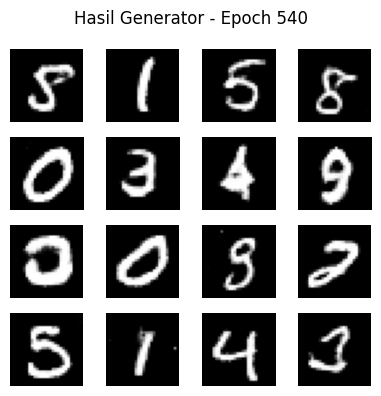

Epoch 541/1000 | noise_std=0.046 | gen_loss=0.7993 | disc_loss=1.3765 | 9.0s
Epoch 542/1000 | noise_std=0.046 | gen_loss=0.7994 | disc_loss=1.3763 | 9.1s
Epoch 543/1000 | noise_std=0.046 | gen_loss=0.7994 | disc_loss=1.3763 | 9.0s
Epoch 544/1000 | noise_std=0.046 | gen_loss=0.7994 | disc_loss=1.3762 | 9.1s
Epoch 545/1000 | noise_std=0.046 | gen_loss=0.7994 | disc_loss=1.3763 | 9.0s
Epoch 546/1000 | noise_std=0.045 | gen_loss=0.7991 | disc_loss=1.3766 | 9.0s


E0000 00:00:1767420342.390271      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 547/1000 | noise_std=0.045 | gen_loss=0.7994 | disc_loss=1.3763 | 9.0s
Epoch 548/1000 | noise_std=0.045 | gen_loss=0.7997 | disc_loss=1.3765 | 9.0s
Epoch 549/1000 | noise_std=0.045 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 550/1000 | noise_std=0.045 | gen_loss=0.7994 | disc_loss=1.3764 | 9.1s


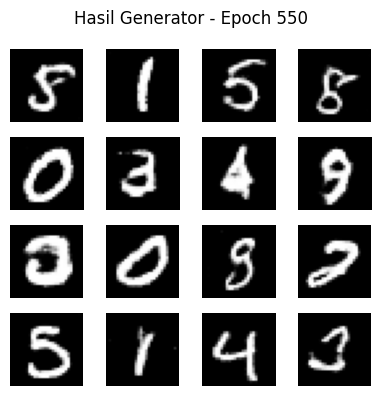

Epoch 551/1000 | noise_std=0.045 | gen_loss=0.7992 | disc_loss=1.3764 | 9.0s
Epoch 552/1000 | noise_std=0.045 | gen_loss=0.7994 | disc_loss=1.3764 | 9.0s
Epoch 553/1000 | noise_std=0.045 | gen_loss=0.7990 | disc_loss=1.3765 | 9.0s


E0000 00:00:1767420405.972855      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 554/1000 | noise_std=0.045 | gen_loss=0.7994 | disc_loss=1.3763 | 9.1s
Epoch 555/1000 | noise_std=0.045 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s
Epoch 556/1000 | noise_std=0.044 | gen_loss=0.7992 | disc_loss=1.3764 | 9.0s
Epoch 557/1000 | noise_std=0.044 | gen_loss=0.7994 | disc_loss=1.3764 | 9.1s
Epoch 558/1000 | noise_std=0.044 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s
Epoch 559/1000 | noise_std=0.044 | gen_loss=0.7991 | disc_loss=1.3765 | 9.0s
Epoch 560/1000 | noise_std=0.044 | gen_loss=0.7990 | disc_loss=1.3767 | 9.1s


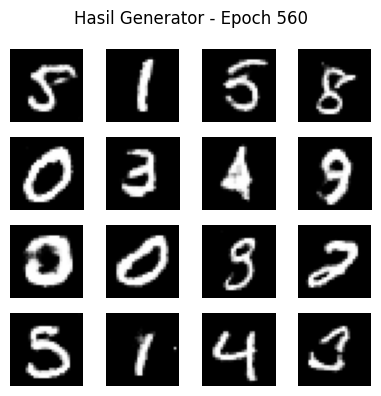

E0000 00:00:1767420469.537553      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 561/1000 | noise_std=0.044 | gen_loss=0.7992 | disc_loss=1.3766 | 9.1s
Epoch 562/1000 | noise_std=0.044 | gen_loss=0.7993 | disc_loss=1.3767 | 9.0s
Epoch 563/1000 | noise_std=0.044 | gen_loss=0.7994 | disc_loss=1.3764 | 9.0s
Epoch 564/1000 | noise_std=0.044 | gen_loss=0.7995 | disc_loss=1.3766 | 9.0s
Epoch 565/1000 | noise_std=0.044 | gen_loss=0.7991 | disc_loss=1.3764 | 9.0s
Epoch 566/1000 | noise_std=0.043 | gen_loss=0.7988 | disc_loss=1.3766 | 9.0s
Epoch 567/1000 | noise_std=0.043 | gen_loss=0.7992 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767420532.851954      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 568/1000 | noise_std=0.043 | gen_loss=0.7991 | disc_loss=1.3766 | 9.0s
Epoch 569/1000 | noise_std=0.043 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 570/1000 | noise_std=0.043 | gen_loss=0.7991 | disc_loss=1.3765 | 9.0s


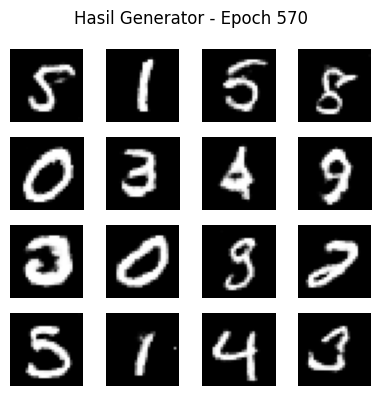

Epoch 571/1000 | noise_std=0.043 | gen_loss=0.8003 | disc_loss=1.3761 | 9.1s
Epoch 572/1000 | noise_std=0.043 | gen_loss=0.7994 | disc_loss=1.3761 | 9.1s
Epoch 573/1000 | noise_std=0.043 | gen_loss=0.7992 | disc_loss=1.3762 | 9.0s
Epoch 574/1000 | noise_std=0.043 | gen_loss=0.7993 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767420596.409332      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 575/1000 | noise_std=0.043 | gen_loss=0.7992 | disc_loss=1.3765 | 9.0s
Epoch 576/1000 | noise_std=0.042 | gen_loss=0.7992 | disc_loss=1.3762 | 9.0s
Epoch 577/1000 | noise_std=0.042 | gen_loss=0.7996 | disc_loss=1.3764 | 9.0s
Epoch 578/1000 | noise_std=0.042 | gen_loss=0.7995 | disc_loss=1.3761 | 9.0s
Epoch 579/1000 | noise_std=0.042 | gen_loss=0.7992 | disc_loss=1.3765 | 9.0s
Epoch 580/1000 | noise_std=0.042 | gen_loss=0.7993 | disc_loss=1.3763 | 9.0s


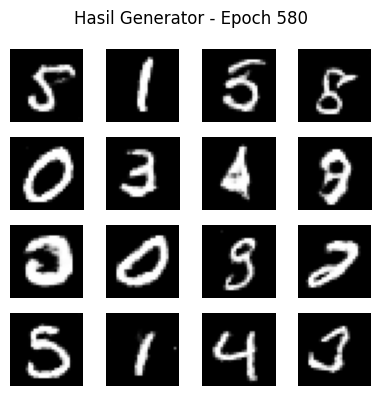

Epoch 581/1000 | noise_std=0.042 | gen_loss=0.7994 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767420660.019604      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 582/1000 | noise_std=0.042 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s
Epoch 583/1000 | noise_std=0.042 | gen_loss=0.7993 | disc_loss=1.3763 | 9.0s
Epoch 584/1000 | noise_std=0.042 | gen_loss=0.7994 | disc_loss=1.3763 | 9.0s
Epoch 585/1000 | noise_std=0.042 | gen_loss=0.7990 | disc_loss=1.3765 | 9.0s
Epoch 586/1000 | noise_std=0.041 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s
Epoch 587/1000 | noise_std=0.041 | gen_loss=0.7993 | disc_loss=1.3765 | 9.0s
Epoch 588/1000 | noise_std=0.041 | gen_loss=0.7991 | disc_loss=1.3765 | 9.0s


E0000 00:00:1767420723.340662      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 589/1000 | noise_std=0.041 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 590/1000 | noise_std=0.041 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s


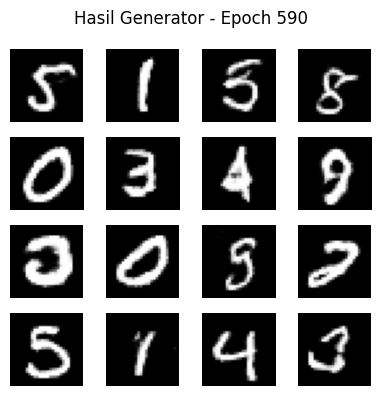

Epoch 591/1000 | noise_std=0.041 | gen_loss=0.7993 | disc_loss=1.3764 | 9.0s
Epoch 592/1000 | noise_std=0.041 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 593/1000 | noise_std=0.041 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 594/1000 | noise_std=0.041 | gen_loss=0.7991 | disc_loss=1.3766 | 9.1s
Epoch 595/1000 | noise_std=0.041 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767420786.961091      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 596/1000 | noise_std=0.040 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s
Epoch 597/1000 | noise_std=0.040 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 598/1000 | noise_std=0.040 | gen_loss=0.7993 | disc_loss=1.3765 | 9.0s
Epoch 599/1000 | noise_std=0.040 | gen_loss=0.7993 | disc_loss=1.3763 | 9.1s
Epoch 600/1000 | noise_std=0.040 | gen_loss=0.7987 | disc_loss=1.3767 | 9.1s


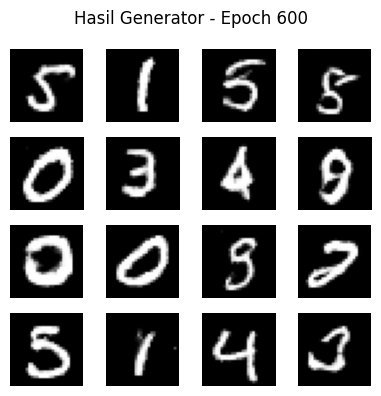

Epoch 601/1000 | noise_std=0.040 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 602/1000 | noise_std=0.040 | gen_loss=0.7989 | disc_loss=1.3764 | 9.0s


E0000 00:00:1767420850.603216      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 603/1000 | noise_std=0.040 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s
Epoch 604/1000 | noise_std=0.040 | gen_loss=0.7993 | disc_loss=1.3763 | 9.1s
Epoch 605/1000 | noise_std=0.040 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 606/1000 | noise_std=0.039 | gen_loss=0.7994 | disc_loss=1.3765 | 9.1s
Epoch 607/1000 | noise_std=0.039 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s
Epoch 608/1000 | noise_std=0.039 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 609/1000 | noise_std=0.039 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767420914.121476      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 610/1000 | noise_std=0.039 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s


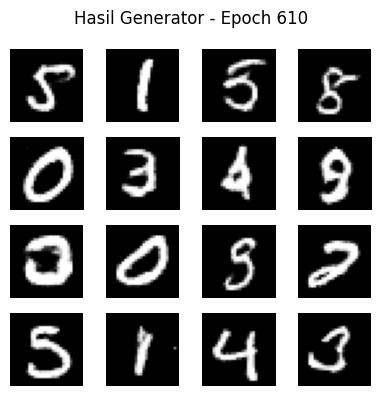

Epoch 611/1000 | noise_std=0.039 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 612/1000 | noise_std=0.039 | gen_loss=0.7989 | disc_loss=1.3765 | 9.0s
Epoch 613/1000 | noise_std=0.039 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s
Epoch 614/1000 | noise_std=0.039 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 615/1000 | noise_std=0.039 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 616/1000 | noise_std=0.038 | gen_loss=0.7990 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767420977.798790      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 617/1000 | noise_std=0.038 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 618/1000 | noise_std=0.038 | gen_loss=0.7995 | disc_loss=1.3763 | 9.1s
Epoch 619/1000 | noise_std=0.038 | gen_loss=0.7991 | disc_loss=1.3765 | 9.0s
Epoch 620/1000 | noise_std=0.038 | gen_loss=0.7991 | disc_loss=1.3762 | 9.0s


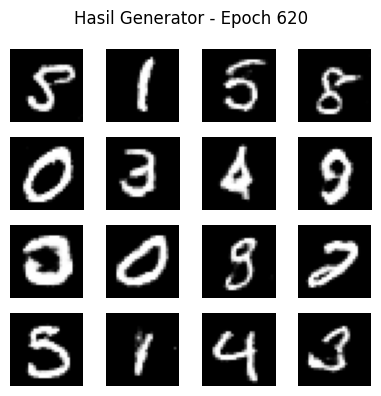

Epoch 621/1000 | noise_std=0.038 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 622/1000 | noise_std=0.038 | gen_loss=0.7994 | disc_loss=1.3765 | 9.1s
Epoch 623/1000 | noise_std=0.038 | gen_loss=0.7991 | disc_loss=1.3763 | 9.0s


E0000 00:00:1767421041.375727      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 624/1000 | noise_std=0.038 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 625/1000 | noise_std=0.038 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 626/1000 | noise_std=0.037 | gen_loss=0.7995 | disc_loss=1.3761 | 9.1s
Epoch 627/1000 | noise_std=0.037 | gen_loss=0.7993 | disc_loss=1.3765 | 9.1s
Epoch 628/1000 | noise_std=0.037 | gen_loss=0.7990 | disc_loss=1.3762 | 9.1s
Epoch 629/1000 | noise_std=0.037 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s
Epoch 630/1000 | noise_std=0.037 | gen_loss=0.7999 | disc_loss=1.3762 | 9.1s


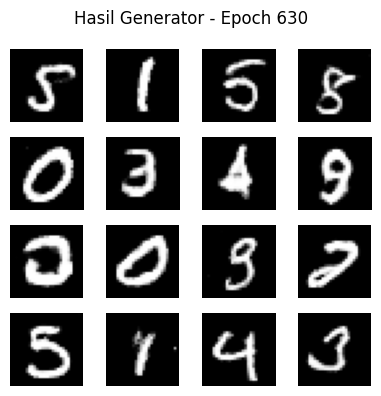

E0000 00:00:1767421105.092477      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 631/1000 | noise_std=0.037 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 632/1000 | noise_std=0.037 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 633/1000 | noise_std=0.037 | gen_loss=0.7993 | disc_loss=1.3763 | 9.0s
Epoch 634/1000 | noise_std=0.037 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 635/1000 | noise_std=0.037 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s
Epoch 636/1000 | noise_std=0.036 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 637/1000 | noise_std=0.036 | gen_loss=0.7992 | disc_loss=1.3765 | 13.4s


E0000 00:00:1767421172.908722      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 638/1000 | noise_std=0.036 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 639/1000 | noise_std=0.036 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 640/1000 | noise_std=0.036 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s


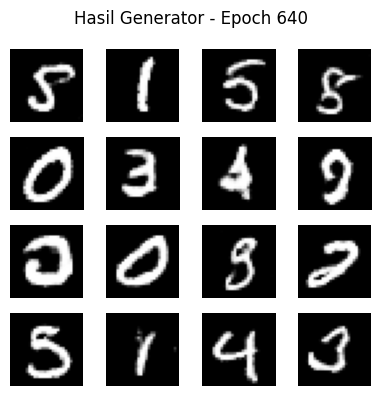

Epoch 641/1000 | noise_std=0.036 | gen_loss=0.7986 | disc_loss=1.3765 | 9.1s
Epoch 642/1000 | noise_std=0.036 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 643/1000 | noise_std=0.036 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 644/1000 | noise_std=0.036 | gen_loss=0.7989 | disc_loss=1.3768 | 9.1s


E0000 00:00:1767421236.642828      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 645/1000 | noise_std=0.036 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 646/1000 | noise_std=0.035 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 647/1000 | noise_std=0.035 | gen_loss=0.7992 | disc_loss=1.3764 | 9.0s
Epoch 648/1000 | noise_std=0.035 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 649/1000 | noise_std=0.035 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 650/1000 | noise_std=0.035 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s


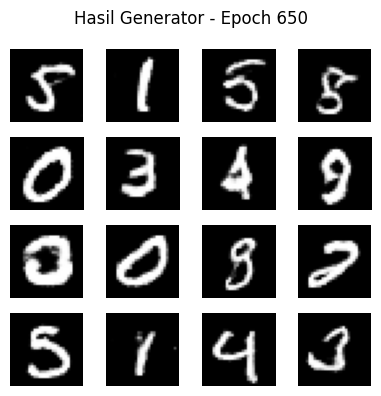

Epoch 651/1000 | noise_std=0.035 | gen_loss=0.7988 | disc_loss=1.3765 | 9.2s


E0000 00:00:1767421300.471768      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 652/1000 | noise_std=0.035 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s
Epoch 653/1000 | noise_std=0.035 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 654/1000 | noise_std=0.035 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 655/1000 | noise_std=0.035 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 656/1000 | noise_std=0.034 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 657/1000 | noise_std=0.034 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 658/1000 | noise_std=0.034 | gen_loss=0.7989 | disc_loss=1.3767 | 9.1s


E0000 00:00:1767421364.218606      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 659/1000 | noise_std=0.034 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 660/1000 | noise_std=0.034 | gen_loss=0.7986 | disc_loss=1.3766 | 9.1s


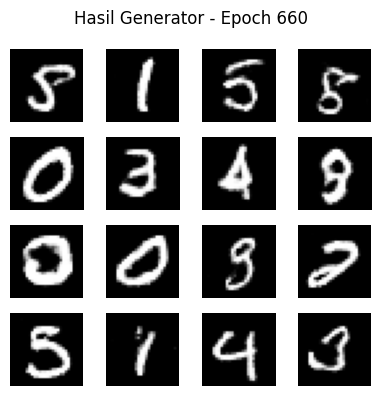

Epoch 661/1000 | noise_std=0.034 | gen_loss=0.7994 | disc_loss=1.3763 | 9.1s
Epoch 662/1000 | noise_std=0.034 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 663/1000 | noise_std=0.034 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 664/1000 | noise_std=0.034 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 665/1000 | noise_std=0.034 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767421428.111540      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 666/1000 | noise_std=0.033 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 667/1000 | noise_std=0.033 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 668/1000 | noise_std=0.033 | gen_loss=0.7993 | disc_loss=1.3763 | 9.1s
Epoch 669/1000 | noise_std=0.033 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 670/1000 | noise_std=0.033 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


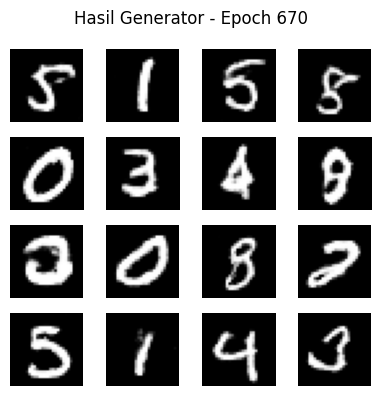

Epoch 671/1000 | noise_std=0.033 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 672/1000 | noise_std=0.033 | gen_loss=0.7987 | disc_loss=1.3766 | 9.0s


E0000 00:00:1767421491.792055      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 673/1000 | noise_std=0.033 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 674/1000 | noise_std=0.033 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s
Epoch 675/1000 | noise_std=0.033 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 676/1000 | noise_std=0.032 | gen_loss=0.7985 | disc_loss=1.3767 | 9.1s
Epoch 677/1000 | noise_std=0.032 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 678/1000 | noise_std=0.032 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 679/1000 | noise_std=0.032 | gen_loss=0.7986 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767421555.303073      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 680/1000 | noise_std=0.032 | gen_loss=0.7994 | disc_loss=1.3764 | 9.1s


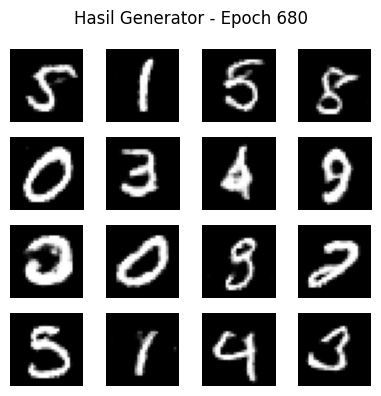

Epoch 681/1000 | noise_std=0.032 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 682/1000 | noise_std=0.032 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s
Epoch 683/1000 | noise_std=0.032 | gen_loss=0.7990 | disc_loss=1.3767 | 9.1s
Epoch 684/1000 | noise_std=0.032 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 685/1000 | noise_std=0.032 | gen_loss=0.7986 | disc_loss=1.3765 | 9.1s
Epoch 686/1000 | noise_std=0.031 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767421619.060951      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 687/1000 | noise_std=0.031 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 688/1000 | noise_std=0.031 | gen_loss=0.7988 | disc_loss=1.3767 | 9.1s
Epoch 689/1000 | noise_std=0.031 | gen_loss=0.7993 | disc_loss=1.3765 | 9.1s
Epoch 690/1000 | noise_std=0.031 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s


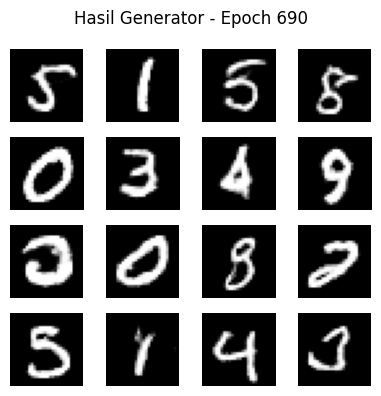

Epoch 691/1000 | noise_std=0.031 | gen_loss=0.7984 | disc_loss=1.3766 | 9.0s
Epoch 692/1000 | noise_std=0.031 | gen_loss=0.7995 | disc_loss=1.3765 | 9.0s
Epoch 693/1000 | noise_std=0.031 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767421682.722917      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 694/1000 | noise_std=0.031 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 695/1000 | noise_std=0.031 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s
Epoch 696/1000 | noise_std=0.030 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 697/1000 | noise_std=0.030 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s
Epoch 698/1000 | noise_std=0.030 | gen_loss=0.7986 | disc_loss=1.3766 | 9.1s
Epoch 699/1000 | noise_std=0.030 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 700/1000 | noise_std=0.030 | gen_loss=0.7992 | disc_loss=1.3766 | 9.1s


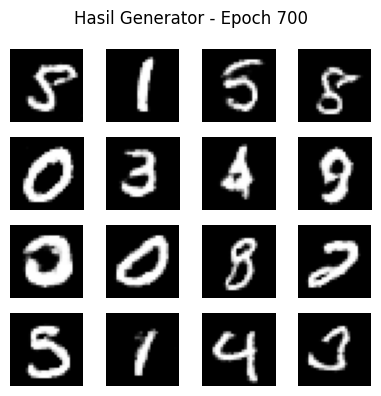

E0000 00:00:1767421746.471075      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 701/1000 | noise_std=0.030 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 702/1000 | noise_std=0.030 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 703/1000 | noise_std=0.030 | gen_loss=0.7991 | disc_loss=1.3762 | 9.1s
Epoch 704/1000 | noise_std=0.030 | gen_loss=0.7990 | disc_loss=1.3766 | 9.1s
Epoch 705/1000 | noise_std=0.030 | gen_loss=0.7988 | disc_loss=1.3764 | 9.0s
Epoch 706/1000 | noise_std=0.029 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 707/1000 | noise_std=0.029 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767421809.982151      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 708/1000 | noise_std=0.029 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 709/1000 | noise_std=0.029 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 710/1000 | noise_std=0.029 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s


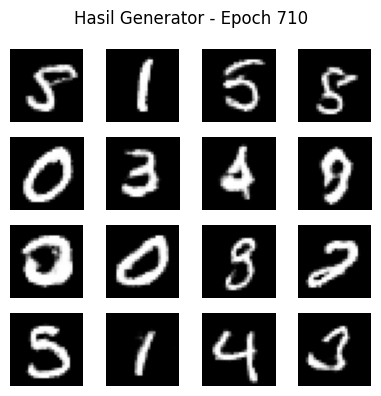

Epoch 711/1000 | noise_std=0.029 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 712/1000 | noise_std=0.029 | gen_loss=0.7985 | disc_loss=1.3768 | 9.0s
Epoch 713/1000 | noise_std=0.029 | gen_loss=0.7990 | disc_loss=1.3766 | 9.1s
Epoch 714/1000 | noise_std=0.029 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767421873.645975      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 715/1000 | noise_std=0.029 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 716/1000 | noise_std=0.028 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 717/1000 | noise_std=0.028 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s
Epoch 718/1000 | noise_std=0.028 | gen_loss=0.7985 | disc_loss=1.3767 | 9.1s
Epoch 719/1000 | noise_std=0.028 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 720/1000 | noise_std=0.028 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s


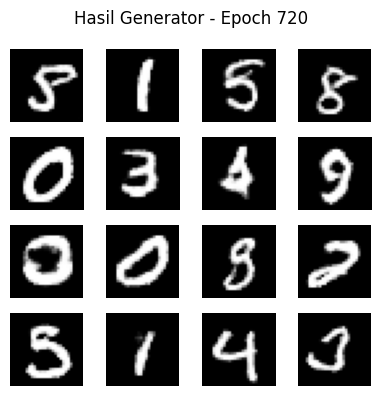

Epoch 721/1000 | noise_std=0.028 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767421937.401211      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 722/1000 | noise_std=0.028 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 723/1000 | noise_std=0.028 | gen_loss=0.7987 | disc_loss=1.3767 | 9.1s
Epoch 724/1000 | noise_std=0.028 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 725/1000 | noise_std=0.028 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 726/1000 | noise_std=0.027 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s
Epoch 727/1000 | noise_std=0.027 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 728/1000 | noise_std=0.027 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767422001.062031      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 729/1000 | noise_std=0.027 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 730/1000 | noise_std=0.027 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s


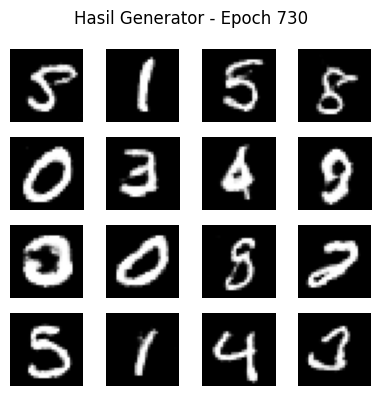

Epoch 731/1000 | noise_std=0.027 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 732/1000 | noise_std=0.027 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 733/1000 | noise_std=0.027 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 734/1000 | noise_std=0.027 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 735/1000 | noise_std=0.027 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767422064.903161      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 736/1000 | noise_std=0.026 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 737/1000 | noise_std=0.026 | gen_loss=0.7987 | disc_loss=1.3767 | 9.1s
Epoch 738/1000 | noise_std=0.026 | gen_loss=0.7986 | disc_loss=1.3765 | 9.1s
Epoch 739/1000 | noise_std=0.026 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 740/1000 | noise_std=0.026 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s


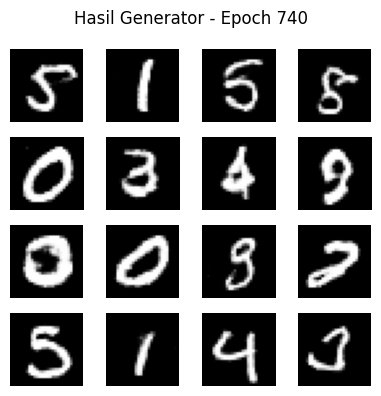

Epoch 741/1000 | noise_std=0.026 | gen_loss=0.7986 | disc_loss=1.3765 | 9.1s
Epoch 742/1000 | noise_std=0.026 | gen_loss=0.7996 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767422128.800807      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 743/1000 | noise_std=0.026 | gen_loss=0.7984 | disc_loss=1.3764 | 9.1s
Epoch 744/1000 | noise_std=0.026 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 745/1000 | noise_std=0.026 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s
Epoch 746/1000 | noise_std=0.025 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 747/1000 | noise_std=0.025 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s
Epoch 748/1000 | noise_std=0.025 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 749/1000 | noise_std=0.025 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767422192.443125      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 750/1000 | noise_std=0.025 | gen_loss=0.7987 | disc_loss=1.3767 | 9.1s


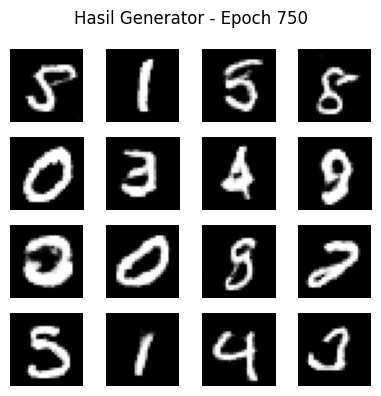

Epoch 751/1000 | noise_std=0.025 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 752/1000 | noise_std=0.025 | gen_loss=0.7989 | disc_loss=1.3766 | 9.1s
Epoch 753/1000 | noise_std=0.025 | gen_loss=0.7985 | disc_loss=1.3766 | 9.1s
Epoch 754/1000 | noise_std=0.025 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 755/1000 | noise_std=0.025 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 756/1000 | noise_std=0.024 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767422256.294775      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 757/1000 | noise_std=0.024 | gen_loss=0.7987 | disc_loss=1.3763 | 9.1s
Epoch 758/1000 | noise_std=0.024 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 759/1000 | noise_std=0.024 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 760/1000 | noise_std=0.024 | gen_loss=0.7991 | disc_loss=1.3766 | 9.1s


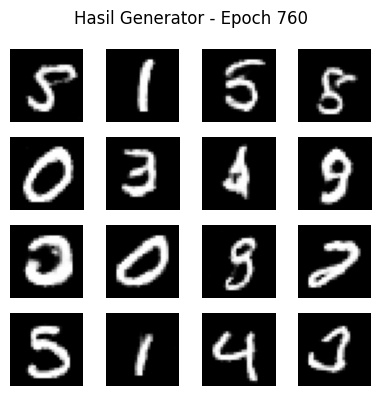

Epoch 761/1000 | noise_std=0.024 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 762/1000 | noise_std=0.024 | gen_loss=0.7986 | disc_loss=1.3765 | 9.1s
Epoch 763/1000 | noise_std=0.024 | gen_loss=0.7987 | disc_loss=1.3767 | 9.1s


E0000 00:00:1767422320.207589      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 764/1000 | noise_std=0.024 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 765/1000 | noise_std=0.024 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s
Epoch 766/1000 | noise_std=0.023 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 767/1000 | noise_std=0.023 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 768/1000 | noise_std=0.023 | gen_loss=0.7990 | disc_loss=1.3766 | 9.1s
Epoch 769/1000 | noise_std=0.023 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 770/1000 | noise_std=0.023 | gen_loss=0.7986 | disc_loss=1.3764 | 9.1s


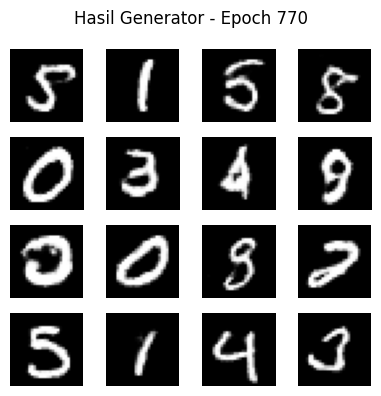

E0000 00:00:1767422389.248629      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 771/1000 | noise_std=0.023 | gen_loss=0.7990 | disc_loss=1.3764 | 9.2s
Epoch 772/1000 | noise_std=0.023 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 773/1000 | noise_std=0.023 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 774/1000 | noise_std=0.023 | gen_loss=0.7989 | disc_loss=1.3763 | 9.1s
Epoch 775/1000 | noise_std=0.023 | gen_loss=0.7987 | disc_loss=1.3767 | 9.1s
Epoch 776/1000 | noise_std=0.022 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 777/1000 | noise_std=0.022 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767422452.924917      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 778/1000 | noise_std=0.022 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 779/1000 | noise_std=0.022 | gen_loss=0.7984 | disc_loss=1.3766 | 9.1s
Epoch 780/1000 | noise_std=0.022 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s


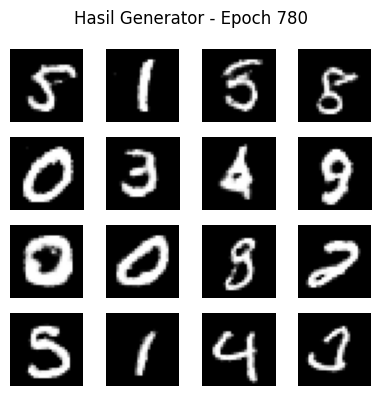

Epoch 781/1000 | noise_std=0.022 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 782/1000 | noise_std=0.022 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 783/1000 | noise_std=0.022 | gen_loss=0.7990 | disc_loss=1.3767 | 9.1s
Epoch 784/1000 | noise_std=0.022 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s


E0000 00:00:1767422516.836635      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 785/1000 | noise_std=0.022 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 786/1000 | noise_std=0.021 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 787/1000 | noise_std=0.021 | gen_loss=0.7991 | disc_loss=1.3762 | 9.1s
Epoch 788/1000 | noise_std=0.021 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 789/1000 | noise_std=0.021 | gen_loss=0.7985 | disc_loss=1.3767 | 9.1s
Epoch 790/1000 | noise_std=0.021 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s


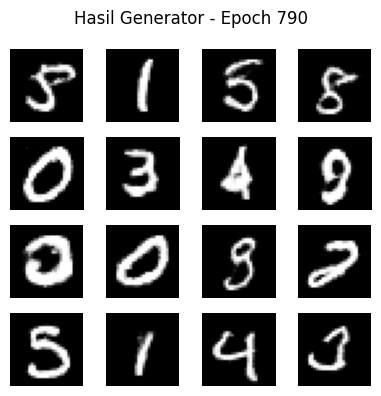

Epoch 791/1000 | noise_std=0.021 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767422580.753185      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 792/1000 | noise_std=0.021 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 793/1000 | noise_std=0.021 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 794/1000 | noise_std=0.021 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 795/1000 | noise_std=0.021 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s
Epoch 796/1000 | noise_std=0.020 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 797/1000 | noise_std=0.020 | gen_loss=0.7988 | disc_loss=1.3767 | 9.1s
Epoch 798/1000 | noise_std=0.020 | gen_loss=0.7985 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767422644.473276      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 799/1000 | noise_std=0.020 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 800/1000 | noise_std=0.020 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


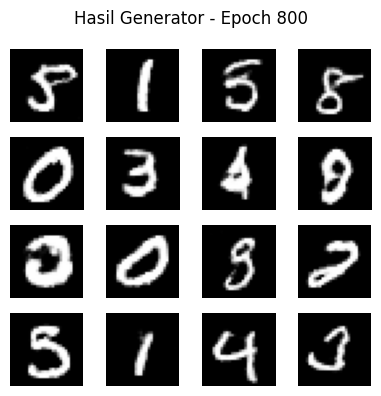

Epoch 801/1000 | noise_std=0.020 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 802/1000 | noise_std=0.020 | gen_loss=0.7986 | disc_loss=1.3765 | 9.1s
Epoch 803/1000 | noise_std=0.020 | gen_loss=0.7991 | disc_loss=1.3766 | 9.1s
Epoch 804/1000 | noise_std=0.020 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 805/1000 | noise_std=0.020 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767422708.334886      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 806/1000 | noise_std=0.019 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 807/1000 | noise_std=0.019 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 808/1000 | noise_std=0.019 | gen_loss=0.7988 | disc_loss=1.3763 | 9.1s
Epoch 809/1000 | noise_std=0.019 | gen_loss=0.7992 | disc_loss=1.3766 | 9.1s
Epoch 810/1000 | noise_std=0.019 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


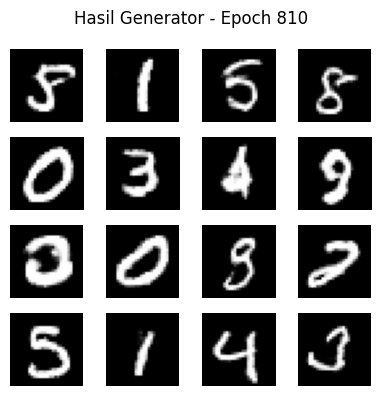

Epoch 811/1000 | noise_std=0.019 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 812/1000 | noise_std=0.019 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767422772.208554      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 813/1000 | noise_std=0.019 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 814/1000 | noise_std=0.019 | gen_loss=0.7986 | disc_loss=1.3766 | 9.1s
Epoch 815/1000 | noise_std=0.019 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 816/1000 | noise_std=0.018 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 817/1000 | noise_std=0.018 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 818/1000 | noise_std=0.018 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 819/1000 | noise_std=0.018 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767422835.885315      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 820/1000 | noise_std=0.018 | gen_loss=0.7992 | disc_loss=1.3766 | 9.1s


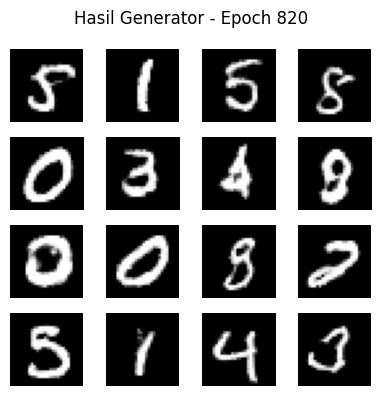

Epoch 821/1000 | noise_std=0.018 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s
Epoch 822/1000 | noise_std=0.018 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s
Epoch 823/1000 | noise_std=0.018 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 824/1000 | noise_std=0.018 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 825/1000 | noise_std=0.018 | gen_loss=0.7985 | disc_loss=1.3766 | 9.2s
Epoch 826/1000 | noise_std=0.017 | gen_loss=0.7993 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767422899.874944      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 827/1000 | noise_std=0.017 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 828/1000 | noise_std=0.017 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 829/1000 | noise_std=0.017 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 830/1000 | noise_std=0.017 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s


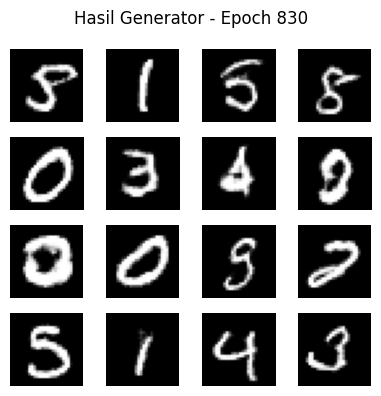

Epoch 831/1000 | noise_std=0.017 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 832/1000 | noise_std=0.017 | gen_loss=0.7992 | disc_loss=1.3765 | 9.1s
Epoch 833/1000 | noise_std=0.017 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767422963.797150      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 834/1000 | noise_std=0.017 | gen_loss=0.7987 | disc_loss=1.3764 | 9.1s
Epoch 835/1000 | noise_std=0.017 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 836/1000 | noise_std=0.016 | gen_loss=0.7987 | disc_loss=1.3766 | 9.1s
Epoch 837/1000 | noise_std=0.016 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 838/1000 | noise_std=0.016 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 839/1000 | noise_std=0.016 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 840/1000 | noise_std=0.016 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s


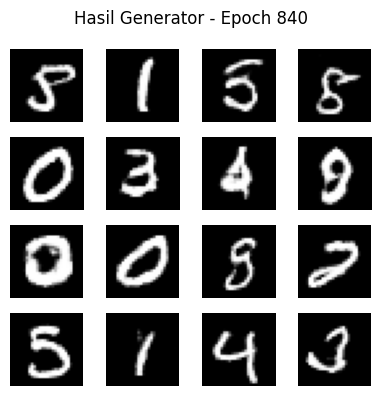

E0000 00:00:1767423027.731809      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 841/1000 | noise_std=0.016 | gen_loss=0.7986 | disc_loss=1.3764 | 9.1s
Epoch 842/1000 | noise_std=0.016 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 843/1000 | noise_std=0.016 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 844/1000 | noise_std=0.016 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 845/1000 | noise_std=0.016 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 846/1000 | noise_std=0.015 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 847/1000 | noise_std=0.015 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767423091.445214      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 848/1000 | noise_std=0.015 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 849/1000 | noise_std=0.015 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 850/1000 | noise_std=0.015 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s


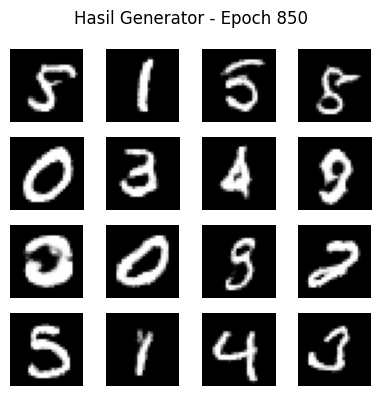

Epoch 851/1000 | noise_std=0.015 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 852/1000 | noise_std=0.015 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 853/1000 | noise_std=0.015 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 854/1000 | noise_std=0.015 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767423155.456781      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 855/1000 | noise_std=0.015 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 856/1000 | noise_std=0.014 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 857/1000 | noise_std=0.014 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 858/1000 | noise_std=0.014 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 859/1000 | noise_std=0.014 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 860/1000 | noise_std=0.014 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s


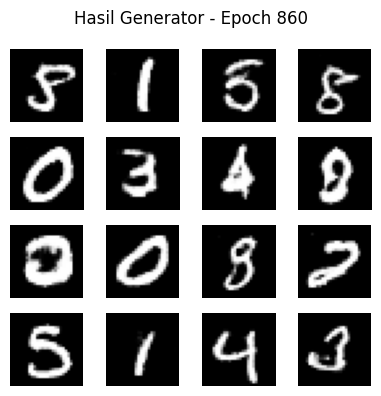

Epoch 861/1000 | noise_std=0.014 | gen_loss=0.7993 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767423219.430235      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 862/1000 | noise_std=0.014 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 863/1000 | noise_std=0.014 | gen_loss=0.7992 | disc_loss=1.3764 | 9.1s
Epoch 864/1000 | noise_std=0.014 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 865/1000 | noise_std=0.014 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 866/1000 | noise_std=0.013 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 867/1000 | noise_std=0.013 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 868/1000 | noise_std=0.013 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767423283.095472      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 869/1000 | noise_std=0.013 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s
Epoch 870/1000 | noise_std=0.013 | gen_loss=0.7986 | disc_loss=1.3767 | 9.1s


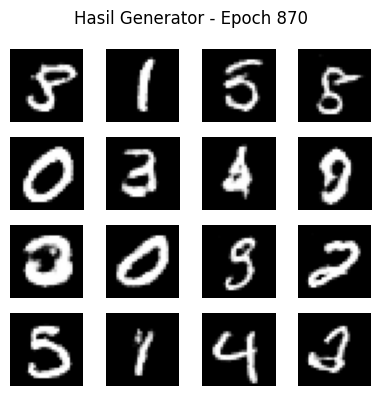

Epoch 871/1000 | noise_std=0.013 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 872/1000 | noise_std=0.013 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 873/1000 | noise_std=0.013 | gen_loss=0.7986 | disc_loss=1.3764 | 9.2s
Epoch 874/1000 | noise_std=0.013 | gen_loss=0.7988 | disc_loss=1.3765 | 9.1s
Epoch 875/1000 | noise_std=0.013 | gen_loss=0.7988 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767423347.220414      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 876/1000 | noise_std=0.012 | gen_loss=0.7991 | disc_loss=1.3765 | 9.1s
Epoch 877/1000 | noise_std=0.012 | gen_loss=0.7990 | disc_loss=1.3766 | 9.1s
Epoch 878/1000 | noise_std=0.012 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 879/1000 | noise_std=0.012 | gen_loss=0.7988 | disc_loss=1.3766 | 9.1s
Epoch 880/1000 | noise_std=0.012 | gen_loss=0.7992 | disc_loss=1.3761 | 9.1s


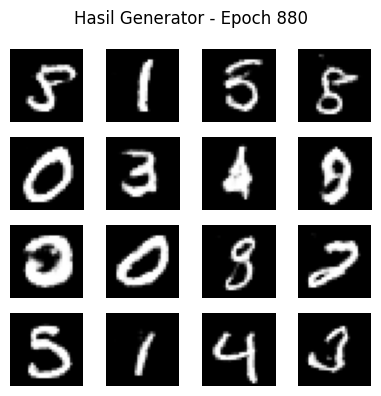

Epoch 881/1000 | noise_std=0.012 | gen_loss=0.7993 | disc_loss=1.3762 | 9.1s
Epoch 882/1000 | noise_std=0.012 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767423411.182059      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 883/1000 | noise_std=0.012 | gen_loss=0.7993 | disc_loss=1.3762 | 9.1s
Epoch 884/1000 | noise_std=0.012 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 885/1000 | noise_std=0.012 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 886/1000 | noise_std=0.011 | gen_loss=0.7989 | disc_loss=1.3763 | 9.1s
Epoch 887/1000 | noise_std=0.011 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 888/1000 | noise_std=0.011 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 889/1000 | noise_std=0.011 | gen_loss=0.7990 | disc_loss=1.3765 | 9.1s


E0000 00:00:1767423474.959027      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 890/1000 | noise_std=0.011 | gen_loss=0.7989 | disc_loss=1.3765 | 9.1s


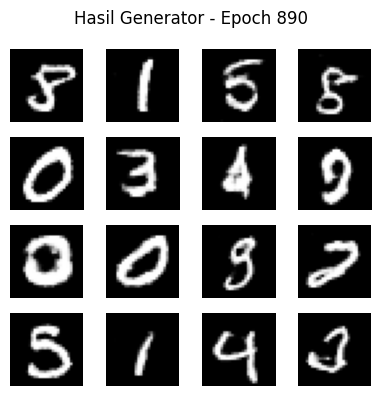

Epoch 891/1000 | noise_std=0.011 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 892/1000 | noise_std=0.011 | gen_loss=0.7990 | disc_loss=1.3764 | 9.2s
Epoch 893/1000 | noise_std=0.011 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 894/1000 | noise_std=0.011 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 895/1000 | noise_std=0.011 | gen_loss=0.7984 | disc_loss=1.3764 | 9.4s
Epoch 896/1000 | noise_std=0.010 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s


E0000 00:00:1767423539.324254      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 897/1000 | noise_std=0.010 | gen_loss=0.7989 | disc_loss=1.3764 | 9.1s
Epoch 898/1000 | noise_std=0.010 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 899/1000 | noise_std=0.010 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s
Epoch 900/1000 | noise_std=0.010 | gen_loss=0.7987 | disc_loss=1.3764 | 9.1s


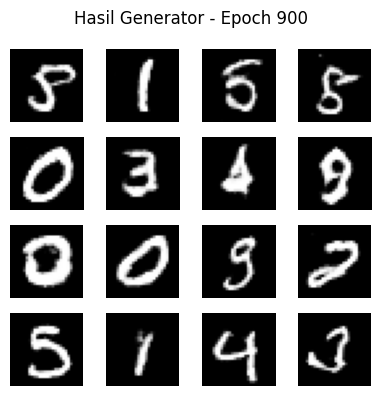

Epoch 901/1000 | noise_std=0.010 | gen_loss=0.7995 | disc_loss=1.3762 | 9.1s
Epoch 902/1000 | noise_std=0.010 | gen_loss=0.7989 | disc_loss=1.3763 | 9.1s
Epoch 903/1000 | noise_std=0.010 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767423603.275672      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 904/1000 | noise_std=0.010 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s
Epoch 905/1000 | noise_std=0.010 | gen_loss=0.7987 | disc_loss=1.3765 | 9.1s
Epoch 906/1000 | noise_std=0.009 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 907/1000 | noise_std=0.009 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s
Epoch 908/1000 | noise_std=0.009 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 909/1000 | noise_std=0.009 | gen_loss=0.7994 | disc_loss=1.3762 | 9.1s
Epoch 910/1000 | noise_std=0.009 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s


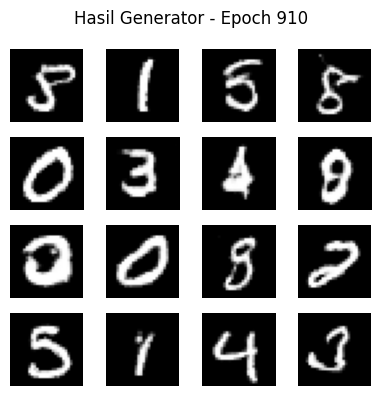

E0000 00:00:1767423667.302330      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 911/1000 | noise_std=0.009 | gen_loss=0.7993 | disc_loss=1.3764 | 9.1s
Epoch 912/1000 | noise_std=0.009 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 913/1000 | noise_std=0.009 | gen_loss=0.7989 | disc_loss=1.3762 | 9.1s
Epoch 914/1000 | noise_std=0.009 | gen_loss=0.7993 | disc_loss=1.3763 | 9.1s
Epoch 915/1000 | noise_std=0.009 | gen_loss=0.7997 | disc_loss=1.3760 | 9.1s
Epoch 916/1000 | noise_std=0.008 | gen_loss=0.7990 | disc_loss=1.3762 | 9.1s
Epoch 917/1000 | noise_std=0.008 | gen_loss=0.7991 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767423731.010769      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 918/1000 | noise_std=0.008 | gen_loss=0.7990 | disc_loss=1.3764 | 9.1s
Epoch 919/1000 | noise_std=0.008 | gen_loss=0.7991 | disc_loss=1.3762 | 9.1s
Epoch 920/1000 | noise_std=0.008 | gen_loss=0.7995 | disc_loss=1.3761 | 9.1s


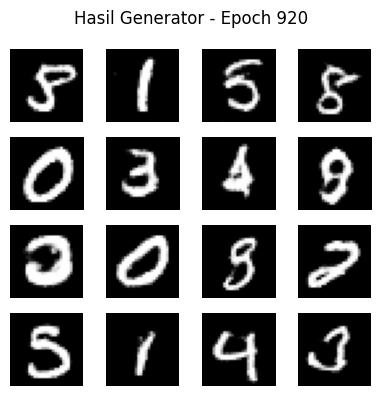

Epoch 921/1000 | noise_std=0.008 | gen_loss=0.7991 | disc_loss=1.3762 | 9.1s
Epoch 922/1000 | noise_std=0.008 | gen_loss=0.7991 | disc_loss=1.3760 | 9.1s
Epoch 923/1000 | noise_std=0.008 | gen_loss=0.7997 | disc_loss=1.3762 | 9.1s
Epoch 924/1000 | noise_std=0.008 | gen_loss=0.7990 | disc_loss=1.3763 | 9.1s


E0000 00:00:1767423794.996300      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 925/1000 | noise_std=0.008 | gen_loss=0.7991 | disc_loss=1.3764 | 9.1s
Epoch 926/1000 | noise_std=0.007 | gen_loss=0.7991 | disc_loss=1.3762 | 9.1s
Epoch 927/1000 | noise_std=0.007 | gen_loss=0.7992 | disc_loss=1.3763 | 9.1s
Epoch 928/1000 | noise_std=0.007 | gen_loss=0.7991 | disc_loss=1.3761 | 9.1s
Epoch 929/1000 | noise_std=0.007 | gen_loss=0.7993 | disc_loss=1.3761 | 9.1s
Epoch 930/1000 | noise_std=0.007 | gen_loss=0.7994 | disc_loss=1.3762 | 9.1s


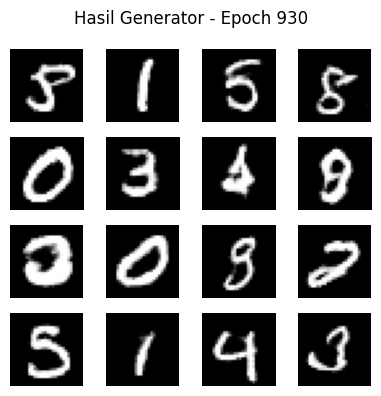

E0000 00:00:1767423856.146690      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 931/1000 | noise_std=0.007 | gen_loss=0.7991 | disc_loss=1.3762 | 9.2s
Epoch 932/1000 | noise_std=0.007 | gen_loss=0.7995 | disc_loss=1.3762 | 9.1s
Epoch 933/1000 | noise_std=0.007 | gen_loss=0.7995 | disc_loss=1.3760 | 9.1s
Epoch 934/1000 | noise_std=0.007 | gen_loss=0.7997 | disc_loss=1.3760 | 9.1s
Epoch 935/1000 | noise_std=0.007 | gen_loss=0.7995 | disc_loss=1.3759 | 9.1s
Epoch 936/1000 | noise_std=0.006 | gen_loss=0.7997 | disc_loss=1.3759 | 9.1s
Epoch 937/1000 | noise_std=0.006 | gen_loss=0.7991 | disc_loss=1.3760 | 9.1s


E0000 00:00:1767423920.021767      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 938/1000 | noise_std=0.006 | gen_loss=0.7999 | disc_loss=1.3759 | 9.1s
Epoch 939/1000 | noise_std=0.006 | gen_loss=0.7994 | disc_loss=1.3759 | 9.1s
Epoch 940/1000 | noise_std=0.006 | gen_loss=0.8001 | disc_loss=1.3759 | 9.1s


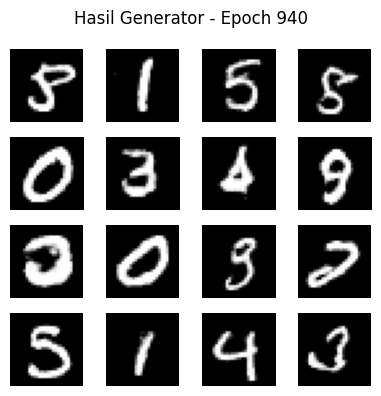

Epoch 941/1000 | noise_std=0.006 | gen_loss=0.7992 | disc_loss=1.3759 | 9.1s
Epoch 942/1000 | noise_std=0.006 | gen_loss=0.7996 | disc_loss=1.3760 | 9.1s
Epoch 943/1000 | noise_std=0.006 | gen_loss=0.7993 | disc_loss=1.3761 | 9.1s
Epoch 944/1000 | noise_std=0.006 | gen_loss=0.7998 | disc_loss=1.3758 | 9.1s


E0000 00:00:1767423983.991897      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 945/1000 | noise_std=0.006 | gen_loss=0.7999 | disc_loss=1.3759 | 9.1s
Epoch 946/1000 | noise_std=0.005 | gen_loss=0.7994 | disc_loss=1.3761 | 9.1s
Epoch 947/1000 | noise_std=0.005 | gen_loss=0.7992 | disc_loss=1.3762 | 9.1s
Epoch 948/1000 | noise_std=0.005 | gen_loss=0.7994 | disc_loss=1.3761 | 9.1s
Epoch 949/1000 | noise_std=0.005 | gen_loss=0.7997 | disc_loss=1.3759 | 9.1s
Epoch 950/1000 | noise_std=0.005 | gen_loss=0.7994 | disc_loss=1.3760 | 9.1s


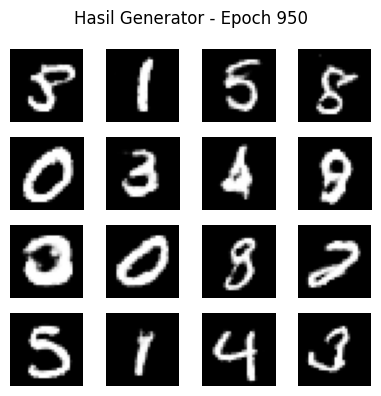

Epoch 951/1000 | noise_std=0.005 | gen_loss=0.7997 | disc_loss=1.3760 | 9.1s


E0000 00:00:1767424048.002761      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 952/1000 | noise_std=0.005 | gen_loss=0.7997 | disc_loss=1.3759 | 9.1s
Epoch 953/1000 | noise_std=0.005 | gen_loss=0.8002 | disc_loss=1.3757 | 9.1s
Epoch 954/1000 | noise_std=0.005 | gen_loss=0.7992 | disc_loss=1.3761 | 9.1s
Epoch 955/1000 | noise_std=0.005 | gen_loss=0.8003 | disc_loss=1.3758 | 9.1s
Epoch 956/1000 | noise_std=0.004 | gen_loss=0.7997 | disc_loss=1.3757 | 9.1s
Epoch 957/1000 | noise_std=0.004 | gen_loss=0.7997 | disc_loss=1.3760 | 9.1s
Epoch 958/1000 | noise_std=0.004 | gen_loss=0.7995 | disc_loss=1.3758 | 9.1s


E0000 00:00:1767424111.765491      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 959/1000 | noise_std=0.004 | gen_loss=0.7998 | disc_loss=1.3756 | 9.1s
Epoch 960/1000 | noise_std=0.004 | gen_loss=0.8001 | disc_loss=1.3755 | 9.1s


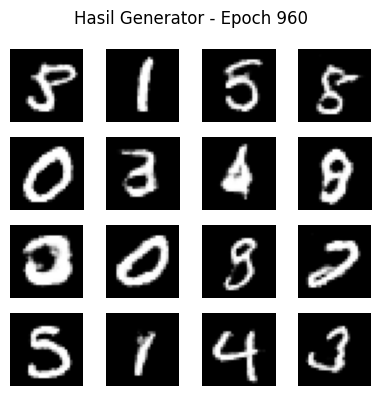

Epoch 961/1000 | noise_std=0.004 | gen_loss=0.8000 | disc_loss=1.3756 | 9.1s
Epoch 962/1000 | noise_std=0.004 | gen_loss=0.7999 | disc_loss=1.3756 | 9.1s
Epoch 963/1000 | noise_std=0.004 | gen_loss=0.8003 | disc_loss=1.3756 | 9.1s
Epoch 964/1000 | noise_std=0.004 | gen_loss=0.7999 | disc_loss=1.3756 | 9.1s
Epoch 965/1000 | noise_std=0.004 | gen_loss=0.8002 | disc_loss=1.3754 | 9.1s


E0000 00:00:1767424175.803383      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 966/1000 | noise_std=0.003 | gen_loss=0.8002 | disc_loss=1.3754 | 9.1s
Epoch 967/1000 | noise_std=0.003 | gen_loss=0.8003 | disc_loss=1.3754 | 9.1s
Epoch 968/1000 | noise_std=0.003 | gen_loss=0.8004 | disc_loss=1.3755 | 9.1s
Epoch 969/1000 | noise_std=0.003 | gen_loss=0.8001 | disc_loss=1.3754 | 9.1s
Epoch 970/1000 | noise_std=0.003 | gen_loss=0.7999 | disc_loss=1.3756 | 9.1s


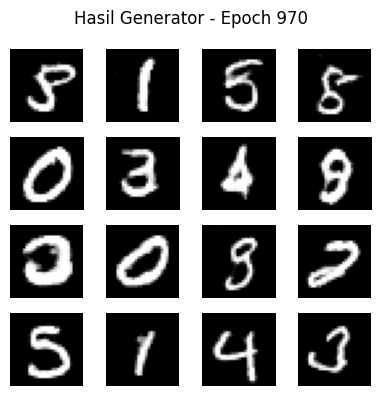

Epoch 971/1000 | noise_std=0.003 | gen_loss=0.8001 | disc_loss=1.3754 | 9.2s
Epoch 972/1000 | noise_std=0.003 | gen_loss=0.8006 | disc_loss=1.3751 | 9.1s


E0000 00:00:1767424239.942991      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 973/1000 | noise_std=0.003 | gen_loss=0.8005 | disc_loss=1.3751 | 9.1s
Epoch 974/1000 | noise_std=0.003 | gen_loss=0.8003 | disc_loss=1.3755 | 9.1s
Epoch 975/1000 | noise_std=0.003 | gen_loss=0.8002 | disc_loss=1.3754 | 9.1s
Epoch 976/1000 | noise_std=0.002 | gen_loss=0.8005 | disc_loss=1.3752 | 9.1s
Epoch 977/1000 | noise_std=0.002 | gen_loss=0.8007 | disc_loss=1.3752 | 9.1s
Epoch 978/1000 | noise_std=0.002 | gen_loss=0.8005 | disc_loss=1.3752 | 9.2s
Epoch 979/1000 | noise_std=0.002 | gen_loss=0.8006 | disc_loss=1.3749 | 9.1s


E0000 00:00:1767424304.048890      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 980/1000 | noise_std=0.002 | gen_loss=0.8007 | disc_loss=1.3748 | 9.4s


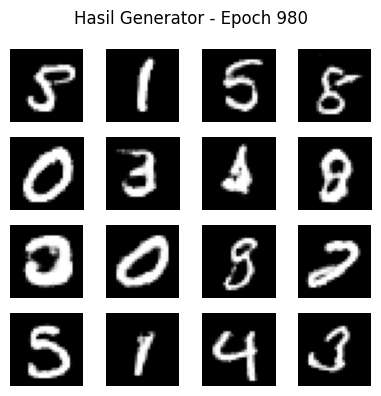

Epoch 981/1000 | noise_std=0.002 | gen_loss=0.8011 | disc_loss=1.3749 | 9.1s
Epoch 982/1000 | noise_std=0.002 | gen_loss=0.8010 | disc_loss=1.3749 | 9.1s
Epoch 983/1000 | noise_std=0.002 | gen_loss=0.8010 | disc_loss=1.3748 | 9.1s
Epoch 984/1000 | noise_std=0.002 | gen_loss=0.8009 | disc_loss=1.3750 | 9.1s
Epoch 985/1000 | noise_std=0.002 | gen_loss=0.8009 | disc_loss=1.3749 | 9.2s
Epoch 986/1000 | noise_std=0.001 | gen_loss=0.8009 | disc_loss=1.3749 | 9.1s


E0000 00:00:1767424368.287618      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 987/1000 | noise_std=0.001 | gen_loss=0.8011 | disc_loss=1.3748 | 9.1s
Epoch 988/1000 | noise_std=0.001 | gen_loss=0.8011 | disc_loss=1.3747 | 9.2s
Epoch 989/1000 | noise_std=0.001 | gen_loss=0.8013 | disc_loss=1.3746 | 9.1s
Epoch 990/1000 | noise_std=0.001 | gen_loss=0.8012 | disc_loss=1.3747 | 9.1s


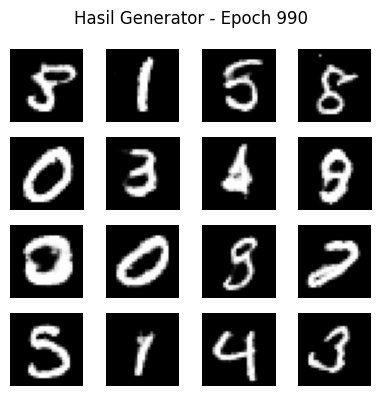

Epoch 991/1000 | noise_std=0.001 | gen_loss=0.8015 | disc_loss=1.3746 | 9.1s
Epoch 992/1000 | noise_std=0.001 | gen_loss=0.8014 | disc_loss=1.3744 | 9.1s
Epoch 993/1000 | noise_std=0.001 | gen_loss=0.8017 | disc_loss=1.3737 | 9.1s


E0000 00:00:1767424432.443546      99 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 994/1000 | noise_std=0.001 | gen_loss=0.8020 | disc_loss=1.3741 | 9.1s
Epoch 995/1000 | noise_std=0.001 | gen_loss=0.8025 | disc_loss=1.3737 | 9.1s
Epoch 996/1000 | noise_std=0.000 | gen_loss=0.8018 | disc_loss=1.3741 | 9.1s
Epoch 997/1000 | noise_std=0.000 | gen_loss=0.8027 | disc_loss=1.3735 | 9.1s
Epoch 998/1000 | noise_std=0.000 | gen_loss=0.8021 | disc_loss=1.3739 | 9.1s
Epoch 999/1000 | noise_std=0.000 | gen_loss=0.8028 | disc_loss=1.3732 | 9.1s
Epoch 1000/1000 | noise_std=0.000 | gen_loss=0.8031 | disc_loss=1.3732 | 9.1s


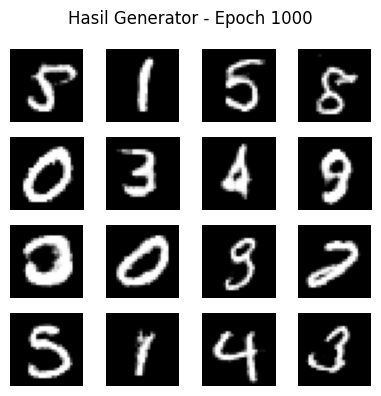

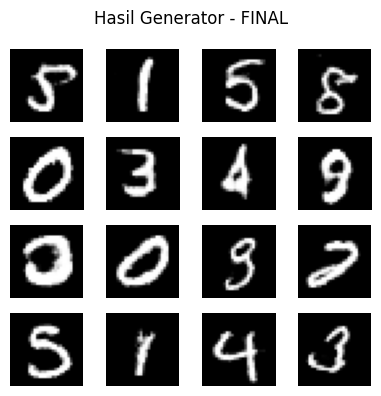

In [ ]:
# TRAIN LOOP
import time

EPOCHS = 1000

gen_history, disc_history = [], []

NOISE_START = 0.10
NOISE_END   = 0.00

for epoch in range(1, EPOCHS + 1):
    start = time.time()

    # linear decay stddev
    t = (epoch - 1) / (EPOCHS - 1)
    noise_std = NOISE_START + t * (NOISE_END - NOISE_START)

    gen_losses, disc_losses = [], []

    for batch in train_dataset:
        gl, dl = train_step(batch, noise_std)
        gen_losses.append(gl)
        disc_losses.append(dl)

    g = float(tf.reduce_mean(gen_losses))
    d = float(tf.reduce_mean(disc_losses))
    gen_history.append(g)
    disc_history.append(d)

    print(f"Epoch {epoch:03d}/{EPOCHS} | noise_std={noise_std:.3f} | gen_loss={g:.4f} | disc_loss={d:.4f} | {time.time()-start:.1f}s")

    if epoch == 1 or epoch % 10 == 0:
        generate_images(f"Hasil Generator - Epoch {epoch}")

generate_images("Hasil Generator - FINAL")


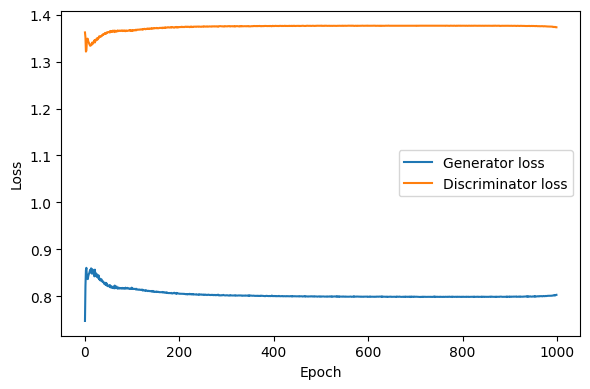

In [ ]:
# PLOT LOSS
plt.figure(figsize=(6,4))
plt.plot(gen_history, label="Generator loss")
plt.plot(disc_history, label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
